Este notebook contem o fluxo de tentantivas com as solucoes de diferentes instancias

No seguinte bloco de Codigo, vamos definir todas as classes que serao utilizadas na pesquisa, dessa maneira, quando quisermos reutiliza-las durante o estudo, nao precisaremos reescrever codigo.

In [2]:
# Importando bibliotecas necessárias 
import pandas as pd
import re
import math
from amplpy import AMPL, DataFrame
import matplotlib.pyplot as plt  # Importar matplotlib para plotar
import numpy as np
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from amplpy import AMPL, Environment


class TTPInstance:
    def __init__(self, arquivo):
        self.arquivo = arquivo
        self.matriz_distancias = None
        self.total_cidades = None
        self.n_item = None
        self.capacity = None
        self.min_speed = None
        self.max_speed = None
        self.rent_ratio = None
        self.df_cidades = None
        self.df_itens = None
        self._ler_instancia()

    def _ler_linha_específica(self, numero_linha):
        with open(self.arquivo, 'r') as file:
            linhas = file.readlines()
            if 1 <= numero_linha <= len(linhas):
                return linhas[numero_linha - 1]
            else:
                raise IndexError(f"Linha {numero_linha} não existe no arquivo.")

    def _ler_arquivo(self):
        with open(self.arquivo, 'r') as file:
            linhas = file.readlines()
        return linhas

    def _extrair_numero(self, linha):
        matches = re.findall(r'\d+\.\d+|\d+', linha)
        if matches:
            return float(matches[-1])
        else:
            raise ValueError(f"Não foi possível extrair um número da linha: {linha}")

    def _ler_instancia(self):
        # Extraindo parâmetros gerais
        self.total_cidades = int(self._extrair_numero(self._ler_linha_específica(3)))
        self.n_item = int(self._extrair_numero(self._ler_linha_específica(4)))
        self.capacity = int(self._extrair_numero(self._ler_linha_específica(5)))
        self.min_speed = self._extrair_numero(self._ler_linha_específica(6))
        self.max_speed = self._extrair_numero(self._ler_linha_específica(7))
        self.rent_ratio = self._extrair_numero(self._ler_linha_específica(8))

        # Lendo as coordenadas das cidades e itens
        linhas = self._ler_arquivo()

        # Encontrar o índice da seção NODE_COORD_SECTION e ITEMS SECTION
        inicio_cidades = None
        inicio_itens = None

        for idx, linha in enumerate(linhas):
            linha_strip = linha.strip()
            if linha_strip.startswith('NODE_COORD_SECTION'):
                inicio_cidades = idx + 1  # A próxima linha é o início dos dados das cidades
            elif linha_strip.startswith('ITEMS SECTION'):
                inicio_itens = idx + 1  # A próxima linha é o início dos dados dos itens
                break  # Após encontrar ITEMS SECTION, não precisamos continuar

        if inicio_cidades is None or inicio_itens is None:
            raise ValueError("Não foi possível encontrar as seções NODE_COORD_SECTION ou ITEMS SECTION no arquivo.")

        # **Correção Aqui: Ler exatamente 'total_cidades' linhas para cidades**
        cidades_dados = linhas[inicio_cidades : inicio_cidades + self.total_cidades]
        itens_dados = linhas[inicio_itens : inicio_itens + self.n_item]  # Ler exatamente 'n_item' linhas

        # Processando dados das cidades
        cidades = []
        for linha in cidades_dados:
            partes = linha.strip().split()
            if len(partes) >= 3:
                try:
                    index = int(partes[0])
                    x = float(partes[1])
                    y = float(partes[2])
                    if index == 0:
                        print(f"Aviso: Cidade 0 encontrada e será ignorada: {linha.strip()}")
                        continue  # Ignorar cidade 0
                    cidades.append({'index': index, 'x': x, 'y': y})
                except ValueError as e:
                    print(f"Erro ao processar linha de cidade: {linha.strip()} - {e}")
            else:
                print(f"Linha de cidade com formato inválido e será ignorada: {linha.strip()}")

        self.df_cidades = pd.DataFrame(cidades)
        self.df_cidades.set_index('index', inplace=True)

        # **Depuração: Verificar se todas as cidades foram lidas**
        print(f"Cidades lidas: {self.df_cidades.index.tolist()} (Total: {len(self.df_cidades)})")
        assert all(city > 0 for city in self.df_cidades.index), "Erro: Cidade 0 está presente nas cidades lidas!"

        # Processando dados dos itens
        itens = []
        for linha in itens_dados:
            partes = linha.strip().split()
            if len(partes) >=4:
                try:
                    index = int(partes[0])
                    profit = float(partes[1])
                    weight = float(partes[2])
                    cidade = int(partes[3])  # Garantir que 'cidade' seja int
                    if cidade ==0:
                        print(f"Aviso: Item {index} está na cidade 0 e será ignorado.")
                        continue  # Ignorar itens na cidade 0
                    if cidade not in self.df_cidades.index:
                        print(f"Aviso: Item {index} está em uma cidade inexistente ({cidade}) e será ignorado.")
                        continue  # Ignorar itens em cidades inexistentes
                    # **Usar 'item_id' como chave**
                    itens.append({'item_id': index, 'profit': profit, 'weight': weight, 'cidade': cidade})
                except ValueError as e:
                    print(f"Erro ao processar linha de item: {linha.strip()} - {e}")
            else:
                print(f"Linha de item com formato inválido e será ignorada: {linha.strip()}")

        # **Depuração: Verificar a lista de itens antes de criar o DataFrame**
        print(f"Lista de itens antes de criar o DataFrame: {itens}")

        self.df_itens = pd.DataFrame(itens)
        print(f"Colunas de df_itens: {self.df_itens.columns.tolist()}")  # Depuração
        print(f"Tipos de dados de df_itens:\n{self.df_itens.dtypes}")  # Depuração

        # Remover espaços em branco nos nomes das colunas, se houver
        self.df_itens.columns = [col.strip() for col in self.df_itens.columns]
        print(f"Colunas após strip: {self.df_itens.columns.tolist()}")  # Depuração

        # Converter 'cidade' para int, se ainda não estiver
        self.df_itens['cidade'] = self.df_itens['cidade'].astype(int)
        print(f"Tipos de dados de df_itens após conversão:\n{self.df_itens.dtypes}")  # Depuração

        try:
            self.df_itens.set_index('item_id', inplace=True)
            print("Índice definido com sucesso.")
        except KeyError as e:
            print(f"Erro ao definir índice: {e}")
            print(f"Colunas disponíveis: {self.df_itens.columns.tolist()}")

        # **Depuração: Verificar se todos os itens foram lidos**
        print(f"Itens lidos: {self.df_itens.index.tolist()} (Total: {len(self.df_itens)})")

        # **Verificar se a Cidade 51 está presente em df_cidades**
        if 51 not in self.df_cidades.index:
            print("Erro: Cidade 51 não está presente em df_cidades!")
        else:
            print("Cidade 51 está presente em df_cidades.")

        # Calculando a matriz de distâncias
        self._calcular_matriz_distancias()

    def _calcular_matriz_distancias(self):
        def calcular_distancia(cidade1, cidade2):
            return math.hypot(cidade2['x'] - cidade1['x'], cidade2['y'] - cidade1['y'])

        self.matriz_distancias = {}
        indices = self.df_cidades.index.tolist()
        for i in indices:
            for j in indices:
                if i != j:
                    dist = calcular_distancia(self.df_cidades.loc[i], self.df_cidades.loc[j])
                    self.matriz_distancias[i, j] = dist
                else:
                    self.matriz_distancias[i, j] = 0  # Distância para si mesmo é zero

        # **Depuração: Verificar algumas distâncias**
        exemplo = [(2,51), (19,44)]
        for pair in exemplo:
            if pair in self.matriz_distancias:
                print(f"Distância entre {pair[0]} e {pair[1]}: {self.matriz_distancias[pair]}")
            else:
                print(f"Distância entre {pair[0]} e {pair[1]} não está definida na matriz_distancias.")

class RoutePlotter:
    def __init__(self, instancia, rota):
        self.instancia = instancia
        self.rota = rota  # Lista de tuplas (i, j)
        # Preparar o DataFrame de cidades com 'cidade' como índice
        if 'cidade' not in self.instancia.df_cidades.columns:
            self.instancia.df_cidades = self.instancia.df_cidades.reset_index().rename(columns={'index': 'cidade'})
        self.df_cidades = self.instancia.df_cidades.set_index('cidade')

    def plotar_rota(self, titulo='Rota Final'):
        df_cidades = self.df_cidades

        # Verificar se todas as cidades na rota estão no DataFrame
        rota_pontos = [i for (i, j) in self.rota] + [self.rota[0][0]]  # Adicionar o retorno à cidade inicial

        missing_cidades = [cidade for cidade in rota_pontos if cidade not in df_cidades.index]
        if missing_cidades:
            print(f"Aviso: As seguintes cidades não estão no DataFrame e serão ignoradas: {missing_cidades}")
            rota_pontos = [cidade for cidade in rota_pontos if cidade in df_cidades.index]

        # Obter as coordenadas da rota final
        rota_coords_x = [df_cidades.loc[cidade]['x'] for cidade in rota_pontos]
        rota_coords_y = [df_cidades.loc[cidade]['y'] for cidade in rota_pontos]

        # Criar figura
        plt.figure(figsize=(10, 8))
        plt.title(titulo)
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')

        # Plotar as cidades
        plt.scatter(df_cidades['x'], df_cidades['y'], c='blue', label='Cidades')

        # Adicionar labels às cidades
        for cidade in df_cidades.index:
            plt.text(df_cidades.loc[cidade]['x'] + 0.5, df_cidades.loc[cidade]['y'] + 0.5, str(cidade), fontsize=9)

        # Plotar a rota
        plt.plot(rota_coords_x, rota_coords_y, c='red', linestyle='-', linewidth=2, marker='o', label='Rota')

        plt.legend()
        plt.grid(True)
        plt.show()

class KPThenTSPSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')

        # Preprocessamento para garantir que 'cidade' está presente
        if 'cidade' not in self.instancia.df_cidades.columns:
            self.instancia.df_cidades = self.instancia.df_cidades.reset_index().rename(columns={'index': 'cidade'})

    def solve(self):
        self._resolver_kp()
        self._resolver_tsp()
        self._calcular_ttp()
        self.resultados()

    def _resolver_kp(self):
        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições
        ampl.setOption('solver', 'gurobi')

        modelo_kp = '''
        param m integer;
        param W;

        param Profit{1..m};
        param Weight{1..m};

        var y{1..m} binary;

        maximize TotalProfit:
            sum {k in 1..m} Profit[k] * y[k];

        subject to KnapsackConstraint:
            sum {k in 1..m} Weight[k] * y[k] <= W;
        '''
        ampl.eval(modelo_kp)

        instancia = self.instancia

        # Ajuste dos índices
        profit_dict = instancia.df_itens['profit'].to_dict()
        weight_dict = instancia.df_itens['weight'].to_dict()
        min_index = min(instancia.df_itens.index)
        if min_index == 0:
            profit_dict = {k+1: v for k, v in profit_dict.items()}
            weight_dict = {k+1: v for k, v in weight_dict.items()}
            item_indices = [k+1 for k in instancia.df_itens.index]
        else:
            item_indices = instancia.df_itens.index.tolist()

        ampl.param['m'] = instancia.n_item
        ampl.param['W'] = instancia.capacity
        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict

        ampl.solve()

        y_sol = ampl.getVariable('y').getValues()
        y_values = y_sol.toDict()

        if min_index == 0:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k+1, 0) > 0.5]
        else:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k, 0) > 0.5]

    def _resolver_tsp(self):
        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições

        cidades_tsp = self.instancia.df_cidades['cidade'].tolist()

        # Definir o nó inicial (usando a primeira cidade da lista)
        start_node = cidades_tsp[0]
        print(f"Start Node: {start_node}")  # Debug: Mostrar o start_node

        # Verificar se start_node está em NODES
        if start_node not in cidades_tsp:
            raise ValueError(f"start_node {start_node} não está na lista de NODES.")

        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES, NODES};
        param start_node;

        var x{NODES, NODES} binary;
        var u{NODES} >= 0;

        minimize TotalDistance:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j];

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES :
            i != j and i != start_node and j != start_node}:
            u[i] - u[j] + n * x[i,j] <= n - 1;
        '''
        ampl.eval(modelo_tsp)

        # Definir sets e parâmetros
        ampl.set['NODES'] = cidades_tsp
        ampl.param['n'] = len(cidades_tsp)

        # Converter a matriz de distâncias para o formato adequado
        distance_dict = {}
        for i in cidades_tsp:
            for j in cidades_tsp:
                if i != j:
                    distance = self.instancia.matriz_distancias.get((i, j), 0)
                    distance_dict[(i, j)] = distance
                else:
                    distance_dict[(i, j)] = 0  # Distância para si mesmo é zero

        ampl.param['Distance'] = distance_dict

        # Definir o nó inicial
        ampl.param['start_node'] = start_node
        print(f"Definido start_node no AMPL: {start_node}")  # Debug

        # Resolver o modelo
        ampl.solve()

        # Verificar se a solução é viável
        if ampl.getObjective('TotalDistance').value() is None:
            print("Nenhuma solução viável encontrada para o TSP.")
            self.rota = cidades_tsp  # Retorna a ordem original das cidades
            return

        # Obter a solução
        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = start_node  # Cidade inicial
        visited = set([current_city])

        while len(visited) < len(cidades_tsp):
            next_city = None
            for j in cidades_tsp:
                if x_values.get((current_city, j), 0) > 0.5 and j not in visited:
                    next_city = j
                    break
            if next_city is None:
                print(f"Não foi possível encontrar a próxima cidade a partir de {current_city}.")
                break  # Nenhuma próxima cidade encontrada
            rota.append((current_city, next_city))
            visited.add(next_city)
            current_city = next_city

        # Fechar o ciclo retornando à cidade inicial
        if len(rota) == len(cidades_tsp) - 1:
            rota.append((current_city, start_node))

        self.rota = rota
        print(f"Rota reconstruída: {self.rota}")  # Debug

    def _calcular_ttp(self):
        # Calcular lucro total considerando a rota e itens selecionados
        instancia = self.instancia

        # Peso acumulado
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0

        for (i, j) in self.rota:
            # Adiciona itens coletados na cidade i
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == i]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcula a velocidade atual
            velocidade = instancia.max_speed - ((peso_acumulado / instancia.capacity) * (instancia.max_speed - instancia.min_speed))
            velocidade = max(velocidade, instancia.min_speed)  # Garantir que a velocidade não seja menor que vmin

            # Tempo para percorrer de i para j
            distancia = instancia.matriz_distancias.get((i, j), 0)
            tempo = distancia / velocidade
            tempo_total += tempo

        custo_aluguel = instancia.rent_ratio * tempo_total

        self.lucro_total = lucro_itens - custo_aluguel

    def resultados(self):
        print("===== KP -> TSP =====")
        print("Rota Ótima:")
        for (i, j) in self.rota:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total}")

class TSPThenKPSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')

    def solve(self):
        self._resolver_tsp()
        self._resolver_kp()
        self._calcular_ttp()

    def _resolver_tsp(self):
        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições

        cidades_tsp = self.instancia.df_cidades['cidade'].tolist()

        # Definir o nó inicial (usando a primeira cidade da lista)
        start_node = cidades_tsp[0]
        print(f"Start Node: {start_node}")  # Debug: Mostrar o start_node

        # Verificar se start_node está em NODES
        if start_node not in cidades_tsp:
            raise ValueError(f"start_node {start_node} não está na lista de NODES.")

        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES, NODES};
        param start_node;

        var x{NODES, NODES} binary;
        var u{NODES} >= 0;

        minimize TotalDistance:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j];

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES :
            i != j and i != start_node and j != start_node}:
            u[i] - u[j] + n * x[i,j] <= n - 1;
        '''
        ampl.eval(modelo_tsp)

        # Definir sets e parâmetros
        ampl.set['NODES'] = cidades_tsp
        ampl.param['n'] = len(cidades_tsp)

        # Converter a matriz de distâncias para o formato adequado
        distance_dict = {}
        for i in cidades_tsp:
            for j in cidades_tsp:
                if i != j:
                    distance = self.instancia.matriz_distancias.get((i, j), 0)
                    distance_dict[(i, j)] = distance
                else:
                    distance_dict[(i, j)] = 0  # Distância para si mesmo é zero

        ampl.param['Distance'] = distance_dict

        # Definir o nó inicial
        ampl.param['start_node'] = start_node
        print(f"Definido start_node no AMPL: {start_node}")  # Debug

        # Resolver o modelo
        ampl.solve()

        # Verificar se a solução é viável
        if ampl.getObjective('TotalDistance').value() is None:
            print("Nenhuma solução viável encontrada para o TSP.")
            self.rota = cidades_tsp  # Retorna a ordem original das cidades
            return

        # Obter a solução
        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = start_node  # Cidade inicial
        visited = set([current_city])

        while len(visited) < len(cidades_tsp):
            next_city = None
            for j in cidades_tsp:
                if x_values.get((current_city, j), 0) > 0.5 and j not in visited:
                    next_city = j
                    break
            if next_city is None:
                print(f"Não foi possível encontrar a próxima cidade a partir de {current_city}.")
                break  # Nenhuma próxima cidade encontrada
            rota.append((current_city, next_city))
            visited.add(next_city)
            current_city = next_city

        # Fechar o ciclo retornando à cidade inicial
        if len(rota) == len(cidades_tsp) - 1:
            rota.append((current_city, start_node))

        self.rota = rota
        print(f"Rota reconstruída: {self.rota}")  # Debug

    def _resolver_kp(self):
        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL
        ampl.setOption('solver', 'gurobi')

        modelo_kp = '''
        param m integer;
        param W;

        param Profit{1..m};
        param Weight{1..m};

        var y{1..m} binary;

        maximize TotalProfit:
            sum {k in 1..m} Profit[k] * y[k];

        subject to KnapsackConstraint:
            sum {k in 1..m} Weight[k] * y[k] <= W;
        '''
        ampl.eval(modelo_kp)

        instancia = self.instancia

        # Ajuste dos índices
        profit_dict = instancia.df_itens['profit'].to_dict()
        weight_dict = instancia.df_itens['weight'].to_dict()
        min_index = min(instancia.df_itens.index)
        if min_index == 0:
            profit_dict = {k+1: v for k, v in profit_dict.items()}
            weight_dict = {k+1: v for k, v in weight_dict.items()}
            item_indices = [k+1 for k in instancia.df_itens.index]
        else:
            item_indices = instancia.df_itens.index.tolist()

        ampl.param['m'] = instancia.n_item
        ampl.param['W'] = instancia.capacity
        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict

        ampl.solve()

        y_sol = ampl.getVariable('y').getValues()
        y_values = y_sol.toDict()

        if min_index == 0:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k+1, 0) > 0.5]
        else:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k, 0) > 0.5]

    def _calcular_ttp(self):
        # Calcular lucro total considerando a rota e itens selecionados
        instancia = self.instancia

        # Peso acumulado
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0

        for (i, j) in self.rota:
            # Adiciona itens coletados na cidade i
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == i]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcula a velocidade atual
            velocidade = instancia.max_speed - ((peso_acumulado / instancia.capacity) * (instancia.max_speed - instancia.min_speed))
            velocidade = max(velocidade, instancia.min_speed)  # Garantir que a velocidade não seja menor que vmin

            # Tempo para percorrer de i para j
            distancia = instancia.matriz_distancias.get((i, j), 0)
            tempo = distancia / velocidade
            tempo_total += tempo

        custo_aluguel = instancia.rent_ratio * tempo_total

        self.lucro_total = lucro_itens - custo_aluguel

    def resultados(self):
        print("===== TSP -> KP =====")
        print("Rota Ótima:")
        for (i, j) in self.rota:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total}")

class TTPIntegratedSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')
        self._definir_modelo()
        self._definir_dados()

    def _definir_modelo(self):
        modelo_ampl = '''
        set NODES;

        param n integer;
        param m integer;
        param W;  # Capacidade máxima da mochila
        param vmax;
        param vmin;
        param R;

        param Profit{ITEMS};
        param Weight{ITEMS};
        param AssignNode{ITEMS};

        param Distance{NODES, NODES};

        var x{NODES, NODES} binary;
        var y{ITEMS} binary;
        var u{NODES} >= 0;

        minimize TotalCost:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j] / (vmax - (vmax - vmin) * (carry(i) / W))
            - sum {k in ITEMS} Profit[k] * y[k] + R * sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j] / (vmax - (vmax - vmin) * (carry(i) / W));

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES : i != j and i != 1 and j != 1}:
            u[i] - u[j] + n * x[i,j] <= n - 1;

        subject to KnapsackConstraint:
            sum {k in ITEMS} Weight[k] * y[k] <= W;

        # Função para calcular o peso carregado na cidade i
        param carry {i in NODES} := sum {k in ITEMS : AssignNode[k] == i} Weight[k] * y[k];

        set ITEMS := 1..m;
        '''
        self.ampl.eval(modelo_ampl)

    def _definir_dados(self):
        ampl = self.ampl
        instancia = self.instancia

        ampl.set['NODES'] = instancia.df_cidades.index.tolist()
        ampl.param['n'] = instancia.total_cidades
        ampl.param['m'] = instancia.n_item
        ampl.param['W'] = instancia.capacity
        ampl.param['vmax'] = instancia.max_speed
        ampl.param['vmin'] = instancia.min_speed
        ampl.param['R'] = instancia.rent_ratio

        # Ajuste de índices se necessário
        profit_dict = instancia.df_itens['profit'].to_dict()
        weight_dict = instancia.df_itens['weight'].to_dict()
        assign_node_dict = instancia.df_itens['cidade'].to_dict()

        # Verificar se os índices começam em 0 ou 1
        min_index = min(instancia.df_itens.index)
        if min_index == 0:
            profit_dict = {k+1: v for k, v in profit_dict.items()}
            weight_dict = {k+1: v for k, v in weight_dict.items()}
            assign_node_dict = {k+1: v for k, v in assign_node_dict.items()}
            item_indices = [k+1 for k in instancia.df_itens.index]
        else:
            item_indices = instancia.df_itens.index.tolist()

        ampl.set['ITEMS'] = item_indices

        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict
        ampl.param['AssignNode'] = assign_node_dict

        # Ajustar a matriz de distâncias para usar índices coerentes
        distance_dict = {}
        for (i, j), dist in instancia.matriz_distancias.items():
            distance_dict[i, j] = dist

        ampl.param['Distance'] = distance_dict

    def solve(self):
        # Configurar opções adicionais se necessário
        ampl.setOption('relax_integrality', True)

        # Solução do modelo
        try:
            self.ampl.solve()
            self._extrair_resultados()
        except Exception as e:
            print("Erro ao resolver o modelo integrado:", e)
            self.rota = []
            self.itens_selecionados = []
            self.lucro_total = None

    def _extrair_resultados(self):
        ampl = self.ampl

        x_sol = ampl.getVariable('x').getValues()
        y_sol = ampl.getVariable('y').getValues()

        # Convertendo os valores de x e y para dicionários
        x_values = x_sol.toDict()
        y_values = y_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = 1  # Supondo que a cidade inicial é a de índice 1
        visited = set()
        while True:
            visited.add(current_city)
            # Obter as cidades adjacentes a current_city com x[current_city, j] > 0.5
            next_cities = [j for j in self.instancia.df_cidades.index if x_values.get((current_city, j), 0) > 0.5]
            if not next_cities or next_cities[0] in visited:
                break
            next_city = next_cities[0]
            rota.append((current_city, next_city))
            current_city = next_city

        self.rota = rota

        # Ajustar índices se necessário
        min_index = min(self.instancia.df_itens.index)
        if min_index == 0:
            itens_selecionados = [k for k in self.instancia.df_itens.index if y_values.get(k+1, 0) > 0.5]
        else:
            itens_selecionados = [k for k in self.instancia.df_itens.index if y_values.get(k, 0) > 0.5]
        self.itens_selecionados = itens_selecionados

        # Lucro total
        self.lucro_total = ampl.getObjective('TotalCost').value()

    def resultados(self):
        print("===== TTP Integrado =====")
        if not self.rota or not self.itens_selecionados or self.lucro_total is None:
            print("Não foi possível resolver o modelo integrado.")
            return

        print("Rota Ótima:")
        for (i, j) in self.rota:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total}")



In [3]:
# Executando nossa primeira Instancia
arquivo_instancia = 'data/eil51_n50_bounded-strongly-corr_01.txt'
instancia = TTPInstance(arquivo_instancia)

Cidades lidas: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51] (Total: 51)
Lista de itens antes de criar o DataFrame: [{'item_id': 1, 'profit': 101.0, 'weight': 1.0, 'cidade': 2}, {'item_id': 2, 'profit': 202.0, 'weight': 2.0, 'cidade': 3}, {'item_id': 3, 'profit': 404.0, 'weight': 4.0, 'cidade': 4}, {'item_id': 4, 'profit': 202.0, 'weight': 2.0, 'cidade': 5}, {'item_id': 5, 'profit': 996.0, 'weight': 896.0, 'cidade': 6}, {'item_id': 6, 'profit': 1992.0, 'weight': 1792.0, 'cidade': 7}, {'item_id': 7, 'profit': 3984.0, 'weight': 3584.0, 'cidade': 8}, {'item_id': 8, 'profit': 467.0, 'weight': 367.0, 'cidade': 9}, {'item_id': 9, 'profit': 934.0, 'weight': 734.0, 'cidade': 10}, {'item_id': 10, 'profit': 1868.0, 'weight': 1468.0, 'cidade': 11}, {'item_id': 11, 'profit': 790.0, 'weight': 690.0, 'cidade': 12}, {'item_id': 12, 'profit': 790.0, 'wei

Solucao Resolvendo ps metodos exatos de forma separada, primeiro KP depois TSP sem alteracoes

inicio KPThenTSPSolver
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 7124
2 simplex iterations
1 branching node
Start Node: 1
Definido start_node no AMPL: 1
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 459
15415 simplex iterations
673 branching nodes
Rota reconstruída: [(1, 32), (32, 11), (11, 38), (38, 5), (5, 49), (49, 10), (10, 39), (39, 33), (33, 45), (45, 15), (15, 37), (37, 17), (17, 44), (44, 42), (42, 40), (40, 19), (19, 41), (41, 13), (13, 25), (25, 14), (14, 18), (18, 4), (4, 47), (47, 12), (12, 46), (46, 51), (51, 27), (27, 6), (6, 48), (48, 23), (23, 24), (24, 43), (43, 7), (7, 26), (26, 8), (8, 31), (31, 28), (28, 3), (3, 36), (36, 35), (35, 20), (20, 29), (29, 21), (21, 34), (34, 30), (30, 9), (9, 50), (50, 16), (16, 2), (2, 22), (22, 1)]
===== KP -> TSP =====
Rota Ótima:
Cidade 1 -> Cidade 32
Cidade 32 -> Cidade 11
Cidade 11 -> Cidade 38
Cidade 38 -> Cidade 5
Cidade 5 -> Cidade 49
Cidade 49 -> Cidade 10
Cidade 10 -> Cidade 39
Cidade 39 -> Cidade 33

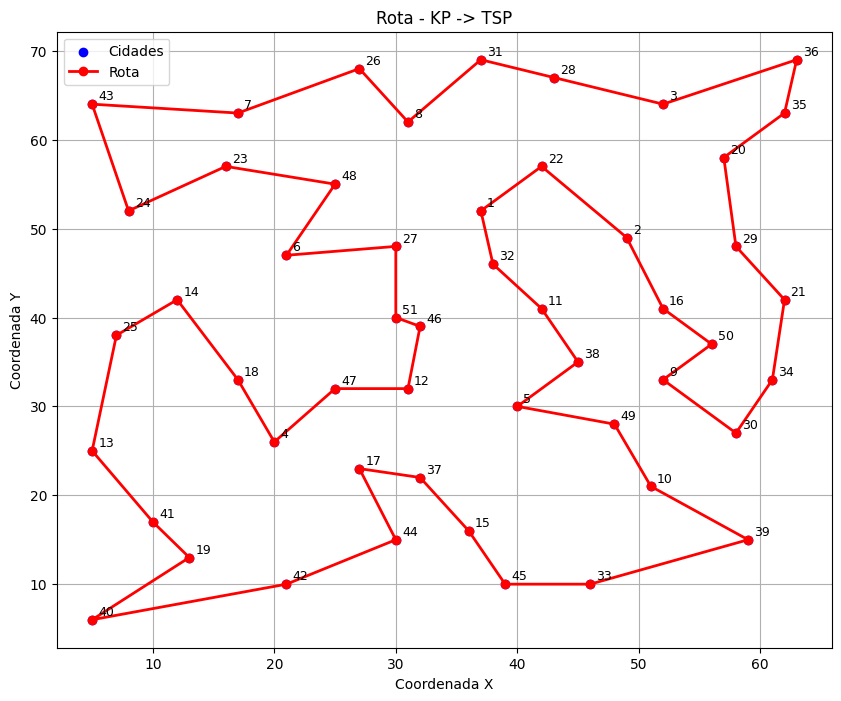

In [13]:

# Resolver primeiro o KP, depois o TSP
solver_kp_tsp = KPThenTSPSolver(instancia)
print("inicio KPThenTSPSolver")
solver_kp_tsp.solve()
print("Finalizado KPThenTSPSolver")
solver_kp_tsp.resultados()

plotter = RoutePlotter(instancia, solver_kp_tsp.rota)
plotter.plotar_rota(titulo='Rota - KP -> TSP')

Solucao resolvendo primeiro TSP depois KP

In [ ]:
# Resolver primeiro o TSP, depois o KP
solver_tsp_kp = TSPThenKPSolver(instancia)
print("inicio TSPThenKPSolver")
solver_tsp_kp.solve()
print("Finalizado TSPThenKPSolver")
solver_tsp_kp.resultados()

plotter = RoutePlotter(instancia, solver_tsp_kp.rota)
plotter.plotar_rota(titulo='Rota - TSP -> KP')

Solucao Integrada, ainda nao consegui rodar por conta de nao linearizacao

In [ ]:
# Resolver o TTP integrado
solver_integrado = TTPIntegratedSolver(instancia)
print("inicio TSPThenKPSolver")
print("Data e Hora de Início:", datetime.now())
solver_integrado.solve()
print("Finalizado TSPThenKPSolver", datetime.now())
solver_integrado.resultados()

plotter = RoutePlotter(instancia, solver_integrado.rota)
plotter.plotar_rota(titulo='Rota - TSP -> KP')

Solucao de KP -> 2TSPs

Apos a solucao do KP, eu vou ordenar os items que foram selecionados de acordo com o peso e vou quebrar o problema em dois TSPs, uma rota com a metade dos itens mais leves e outra rota com a metade dos itens mais pesados. No fim eu vou unir os dois TSPs em uma unica rota e calcular o ganho.

Cidades lidas: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51] (Total: 51)
Lista de itens antes de criar o DataFrame: [{'item_id': 1, 'profit': 101.0, 'weight': 1.0, 'cidade': 2}, {'item_id': 2, 'profit': 202.0, 'weight': 2.0, 'cidade': 3}, {'item_id': 3, 'profit': 404.0, 'weight': 4.0, 'cidade': 4}, {'item_id': 4, 'profit': 202.0, 'weight': 2.0, 'cidade': 5}, {'item_id': 5, 'profit': 996.0, 'weight': 896.0, 'cidade': 6}, {'item_id': 6, 'profit': 1992.0, 'weight': 1792.0, 'cidade': 7}, {'item_id': 7, 'profit': 3984.0, 'weight': 3584.0, 'cidade': 8}, {'item_id': 8, 'profit': 467.0, 'weight': 367.0, 'cidade': 9}, {'item_id': 9, 'profit': 934.0, 'weight': 734.0, 'cidade': 10}, {'item_id': 10, 'profit': 1868.0, 'weight': 1468.0, 'cidade': 11}, {'item_id': 11, 'profit': 790.0, 'weight': 690.0, 'cidade': 12}, {'item_id': 12, 'profit': 790.0, 'wei

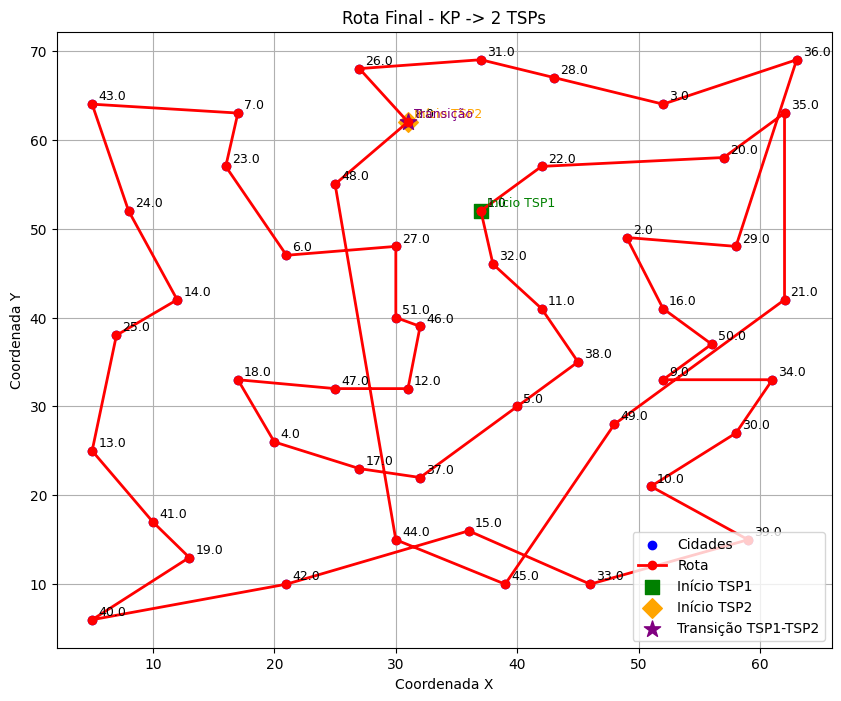

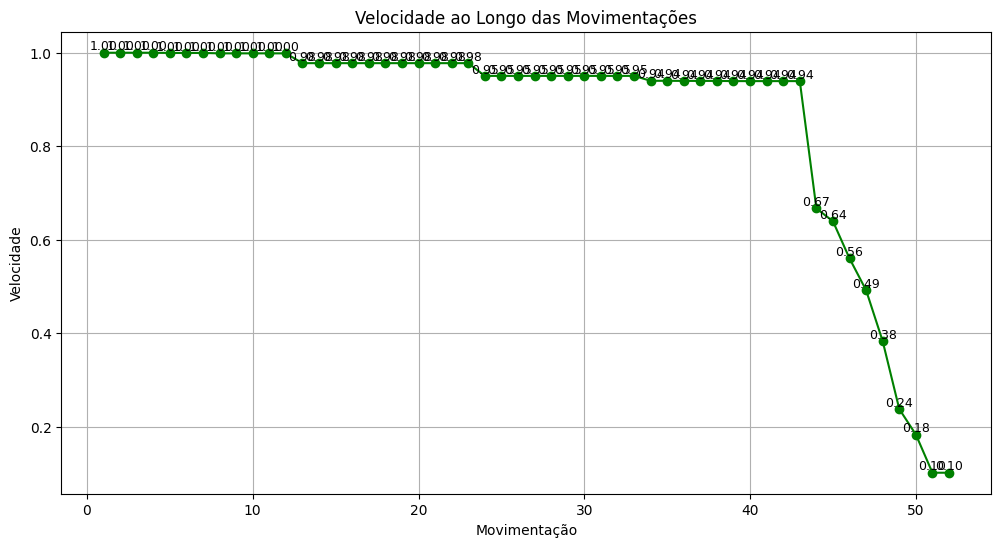

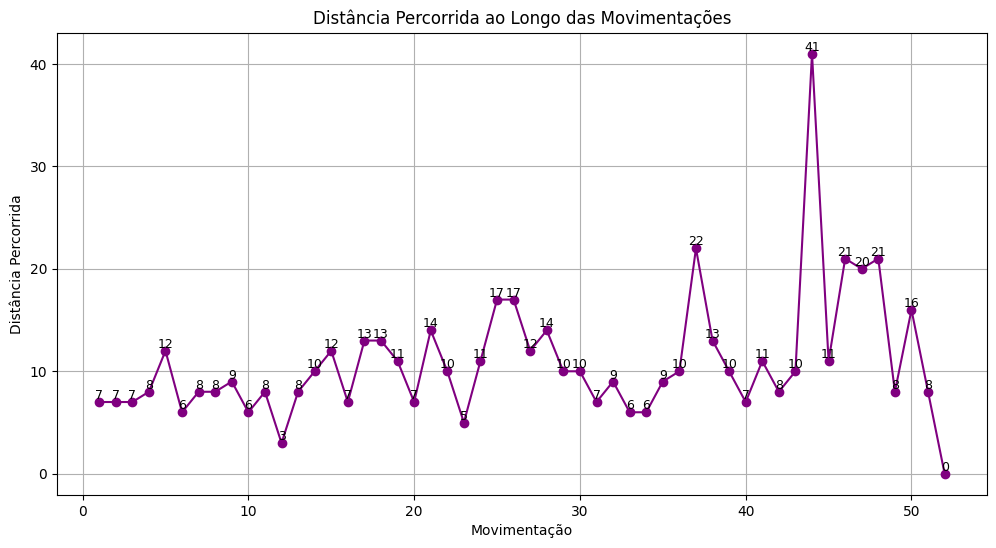

In [40]:
import pandas as pd
from amplpy import AMPL
import matplotlib.pyplot as plt
import math

class KPThen2TSPsSolver:
    def __init__(self, instancia):
        """
        Inicializa o solver com a instância do problema.

        Args:
            instancia: Objeto que contém os DataFrames df_cidades e df_itens, 
                      matriz_distancias, capacidade da mochila, velocidades, etc.
        """
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')  # Assegure-se de que o solver está instalado

        # Garantir que 'cidade' está presente em df_cidades
        if 'cidade' not in self.instancia.df_cidades.columns:
            # Verificar se 'cidade' está como índice
            if self.instancia.df_cidades.index.name == 'cidade':
                self.instancia.df_cidades.reset_index(inplace=True)
                print("Coluna 'cidade' adicionada a df_cidades a partir do índice.")
            else:
                # Adicionar 'cidade' como uma coluna sequencial ou de acordo com a lógica do problema
                # Aqui, assumimos que as cidades são numeradas sequencialmente começando de 1
                self.instancia.df_cidades.reset_index(drop=True, inplace=True)
                self.instancia.df_cidades.insert(0, 'cidade', range(1, len(self.instancia.df_cidades) + 1))
                print("Coluna 'cidade' adicionada a df_cidades como sequência numérica.")

        # Verificar se 'cidade' agora está presente
        if 'cidade' not in self.instancia.df_cidades.columns:
            raise ValueError("A coluna 'cidade' não está presente em df_cidades e não pôde ser adicionada automaticamente.")

        # Preprocessamento para garantir que 'cidade' está presente e é inteiro em df_itens
        if 'cidade' not in self.instancia.df_itens.columns:
            self.instancia.df_itens = self.instancia.df_itens.reset_index().rename(columns={'index': 'cidade'})
            print("Coluna 'cidade' adicionada a df_itens a partir do índice.")
        else:
            print("Coluna 'cidade' já existe em df_itens.")

        # Converter os identificadores de 'cidade' para inteiros, se necessário
        if not pd.api.types.is_integer_dtype(self.instancia.df_itens['cidade']):
            self.instancia.df_itens['cidade'] = self.instancia.df_itens['cidade'].astype(int)
            print("Convertendo identificadores de 'cidade' para inteiros em df_itens.")

        # Excluir itens que estão associados a cidades que não existem em df_cidades
        cidades_existentes = set(self.instancia.df_cidades['cidade'].tolist())
        itens_validos = self.instancia.df_itens[self.instancia.df_itens['cidade'].isin(cidades_existentes)]
        itens_invalidos = self.instancia.df_itens[~self.instancia.df_itens['cidade'].isin(cidades_existentes)]
        if not itens_invalidos.empty:
            print(f"Aviso: Alguns itens estão associados a cidades inexistentes e serão ignorados: {itens_invalidos.index.tolist()}")
        self.instancia.df_itens = itens_validos

        # Gerar a matriz de distâncias completa com CEIL_2D
        self._gerar_matriz_distancias()

        # Inicialização das variáveis
        self.itens_selecionados = []
        self.itens_leves = []
        self.itens_pesados = []
        self.rota1 = []
        self.rota2 = []
        self.rota_final = []
        self.lucro_total = 0
        self.velocidades = []  # Lista para armazenar velocidades em cada movimentação
        self.distancias = []    # Lista para armazenar distâncias em cada movimentação

    def _gerar_matriz_distancias(self):
        """
        Gera a matriz de distâncias completa utilizando as coordenadas das cidades.
        Aplica a função CEIL_2D para arredondar as distâncias para cima.
        """
        cidades = self.instancia.df_cidades['cidade'].tolist()
        coordenadas = self.instancia.df_cidades.set_index('cidade')[['x', 'y']].to_dict('index')
        matriz_distancias = {}

        for i in cidades:
            for j in cidades:
                if i != j:
                    xi, yi = coordenadas[i]['x'], coordenadas[i]['y']
                    xj, yj = coordenadas[j]['x'], coordenadas[j]['y']
                    distancia = math.ceil(math.sqrt((xi - xj)**2 + (yi - yj)**2))
                    matriz_distancias[(i, j)] = distancia
                else:
                    matriz_distancias[(i, j)] = 0  # Distância para si mesmo é zero

        self.instancia.matriz_distancias = matriz_distancias
        print("Matriz de distâncias gerada automaticamente com CEIL_2D.")

    def solve(self):
        """
        Executa o processo completo de resolução: KP, divisão de itens, 2 TSPs e cálculo do lucro.
        """
        print("Iniciando KPThen2TSPsSolver...")
        self._resolver_kp()
        self._dividir_itens()
        self._resolver_duas_tsp()
        self._unir_rotas()
        self._calcular_ttp()
        print("KPThen2TSPsSolver Finalizado.")

    def _resolver_kp(self):
        """
        Resolve o problema de Knapsack (KP) para selecionar itens que maximizam o lucro.
        """
        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições
        ampl.setOption('solver', 'gurobi')

        modelo_kp = '''
        param m integer;
        param W;

        param Profit {1..m};
        param Weight {1..m};

        var y {1..m} binary;

        maximize TotalProfit:
            sum {k in 1..m} Profit[k] * y[k];

        subject to KnapsackConstraint:
            sum {k in 1..m} Weight[k] * y[k] <= W;
        '''
        ampl.eval(modelo_kp)

        instancia = self.instancia

        # Preparar os índices e parâmetros
        profit_dict = {}
        weight_dict = {}
        item_ids = list(instancia.df_itens.index)
        for idx, item_id in enumerate(item_ids, start=1):
            profit_dict[idx] = instancia.df_itens.loc[item_id]['profit']
            weight_dict[idx] = instancia.df_itens.loc[item_id]['weight']

        ampl.param['m'] = len(item_ids)
        ampl.param['W'] = instancia.capacity
        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict

        ampl.solve()

        y_sol = ampl.getVariable('y').getValues()
        y_values = y_sol.toDict()

        # Selecionar itens com y[k] > 0.5
        self.itens_selecionados = []
        for idx, item_id in enumerate(item_ids, start=1):
            if y_values.get(idx, 0) > 0.5:
                self.itens_selecionados.append(item_id)

        print(f"Itens selecionados (KP): {self.itens_selecionados}")

    def _dividir_itens(self):
        """
        Ordena os itens selecionados por peso e divide em dois grupos: 
        metade mais leve e metade mais pesada.
        """
        if not self.itens_selecionados:
            raise ValueError("Nenhum item selecionado após resolver o KP.")

        # Extrair os pesos dos itens selecionados
        itens_df = self.instancia.df_itens.loc[self.itens_selecionados]

        # Ordenar por peso (crescente)
        itens_ordenados = itens_df.sort_values(by='weight', ascending=True)

        # Dividir em dois grupos
        metade = len(itens_ordenados) // 2
        itens_leves = itens_ordenados.iloc[:metade].index.tolist()
        itens_pesados = itens_ordenados.iloc[metade:].index.tolist()

        self.itens_leves = itens_leves
        self.itens_pesados = itens_pesados

        print(f"Metade mais leve dos itens: {self.itens_leves}")
        print(f"Metade mais pesada dos itens: {self.itens_pesados}")

    def _resolver_duas_tsp(self):
        """
        Resolve dois problemas de TSP separadamente para os grupos de itens leves e pesados.
        Garante que o TSP1 sempre comece na cidade 1 e que o TSP2 inicie no final do TSP1.
        O TSP2 terminará na cidade 1.
        """
        # Identificar as cidades envolvidas em cada grupo
        cidades_leves = self.instancia.df_itens.loc[self.itens_leves]['cidade'].unique().tolist()
        cidades_pesadas = self.instancia.df_itens.loc[self.itens_pesados]['cidade'].unique().tolist()

        # Incluir cidades sem itens no TSP1 (Itens Leves)
        todas_cidades_com_itens_leves = set(cidades_leves)
        todas_cidades_com_itens_pesados = set(cidades_pesadas)
        todas_cidades = set(self.instancia.df_cidades['cidade'].tolist())
        cidades_sem_itens = todas_cidades - todas_cidades_com_itens_leves - todas_cidades_com_itens_pesados

        # Evitar incluir cidade 0 (já filtrado no TTPInstance)
        cidades_sem_itens = [cidade for cidade in cidades_sem_itens if cidade > 0]

        # Garantir que o TSP1 comece na cidade 1
        if 1 not in cidades_leves:
            cidades_leves.insert(0, 1)

        # Remover duplicatas mantendo a ordem
        cidades_leves = list(dict.fromkeys(cidades_leves))

        # Incluir cidades sem itens no TSP1
        cidades_leves += list(cidades_sem_itens)

        print(f"Cidades para TSP 1 (Itens Leves + Cidades sem itens): {cidades_leves}")
        print(f"Cidades para TSP 2 (Itens Pesados): {cidades_pesadas}")

        # Resolver TSP para itens leves (TSP1) sem fechar o ciclo
        self.rota1, fim_tsp1 = self._resolver_tsp_para_cidades(cidades_leves, start_node=1, fechar_ciclo=False)
        print(f"Rota 1 (Itens Leves + Cidades sem itens): {self.rota1}")
        print(f"Fim TSP1: {fim_tsp1}")

        # Resolver TSP para itens pesados (TSP2), iniciando no fim do TSP1
        if fim_tsp1 and cidades_pesadas:
            # Incluir a cidade 1 ao final do TSP2 para garantir que ele retorne à cidade 1
            cidades_pesadas.append(1)
            self.rota2, fim_tsp2 = self._resolver_tsp_para_cidades(cidades_pesadas, start_node=fim_tsp1, fechar_ciclo=False)
            print(f"Rota 2 (Itens Pesados): {self.rota2}")
            print(f"Fim TSP2: {fim_tsp2}")
        else:
            print("Nenhuma cidade final do TSP1 para iniciar o TSP2.")
            self.rota2 = []

        # Armazenar a última cidade do TSP2, que deve ser a Cidade 1
        self.fim_tsp2 = 1
        
    
    def _resolver_tsp_para_cidades(self, cidades_tsp, start_node, fechar_ciclo=True):
        """
        Resolve o TSP para um subconjunto de cidades com um nó de início específico.

        Args:
            cidades_tsp (list): Lista de identificadores de cidades para o TSP.
            start_node (int): Identificador da cidade de início.
            fechar_ciclo (bool): Indica se a rota deve retornar ao start_node.

        Returns:
            tuple: (Lista de tuplas representando a rota (i, j), Última cidade da rota)
        """
        # Garantir que o start_node está em cidades_tsp
        if start_node not in cidades_tsp:
            cidades_tsp.insert(0, start_node)

        # Remover duplicatas mantendo a ordem
        cidades_tsp = list(dict.fromkeys(cidades_tsp))

        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições

        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES, NODES};
        param start_node;

        var x{NODES, NODES} binary;
        var u{NODES} >= 0;

        minimize TotalDistance:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j];

        subject to OneOut {i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn {j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination {i in NODES, j in NODES :
            i != j and i != start_node and j != start_node}:
            u[i] - u[j] + n * x[i,j] <= n - 1;

        subject to NoSelfLoop {i in NODES}:
            x[i,i] == 0;
        '''
        ampl.eval(modelo_tsp)

        # Definir sets e parâmetros
        ampl.set['NODES'] = cidades_tsp
        ampl.param['n'] = len(cidades_tsp)
        ampl.param['start_node'] = start_node

        # Verificar a matriz de distâncias
        self._verificar_matriz_distancias(cidades_tsp)

        # Converter a matriz de distâncias para o formato adequado
        distance_dict = {}
        for i in cidades_tsp:
            for j in cidades_tsp:
                distance_dict[(i, j)] = self.instancia.matriz_distancias.get((i, j), 1e6)

        ampl.param['Distance'] = distance_dict

        # Resolver o modelo
        ampl.solve()

        # Obter a solução
        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruir a rota
        rota = []
        current_city = start_node
        visited = set([current_city])

        while len(visited) < len(cidades_tsp):
            next_city = None
            for j in cidades_tsp:
                if j not in visited and x_values.get((current_city, j), 0) > 0.5:
                    next_city = j
                    break
            if next_city is None:
                break
            rota.append((current_city, next_city))
            visited.add(next_city)
            current_city = next_city

        # Fechar o ciclo se necessário
        if fechar_ciclo:
            rota.append((current_city, start_node))

        # Retornar a rota e a última cidade visitada
        fim_tsp = current_city if not fechar_ciclo else start_node
        return rota, fim_tsp

    def _verificar_matriz_distancias(self, cidades_tsp):
        """
        Verifica se todas as combinações de cidades possuem distâncias definidas.

        Args:
            cidades_tsp (list): Lista de identificadores de cidades para o TSP.

        Raises:
            ValueError: Se alguma combinação de cidade não tiver distância definida.
        """
        for i in cidades_tsp:
            for j in cidades_tsp:
                if i != j and (i, j) not in self.instancia.matriz_distancias:
                    raise ValueError(f"Distância entre {i} e {j} não está definida na matriz_distancias.")

    def _unir_rotas(self):
        """
        Une as duas rotas de TSP em uma única rota, formando um ciclo completo.
        """
        # Definir a rota final
        self.rota_final = []

        # Adicionar a rota1 (TSP1)
        if self.rota1:
            self.rota_final += self.rota1

        # Conectar a rota1 com a rota2
        if self.rota1 and self.rota2:
            ultima_cidade_rota1 = self.rota1[-1][1]
            primeira_cidade_rota2 = self.rota2[0][0]
            if ultima_cidade_rota1 != primeira_cidade_rota2:
                self.rota_final.append((ultima_cidade_rota1, primeira_cidade_rota2))

        # Adicionar a rota2 (TSP2)
        if self.rota2:
            self.rota_final += self.rota2

        # **Adicionar a conexão de retorno à Cidade 1 para fechar o ciclo**
        if self.rota_final and hasattr(self, 'fim_tsp2') and self.fim_tsp2:
            self.rota_final.append((self.fim_tsp2, 1))
            print(f"Conectando a última cidade do TSP2 ({self.fim_tsp2}) à Cidade 1.")

        print(f"Rota final unificada: {self.rota_final}")

    def _calcular_ttp(self):
        """
        Calcula o lucro total considerando a rota final e os itens selecionados, 
        levando em conta a velocidade variável.
        """
        instancia = self.instancia

        # Peso acumulado
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0
        total_distancia = 0  # Variável para armazenar a distância total

        for (i, j) in self.rota_final:
            # Adiciona itens coletados na cidade i
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == i]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcula a velocidade atual
            velocidade = instancia.max_speed - ((peso_acumulado / instancia.capacity) * (instancia.max_speed - instancia.min_speed))
            velocidade = max(velocidade, instancia.min_speed)  # Garantir que a velocidade não seja menor que vmin

            # Armazenar a velocidade para plotagem
            self.velocidades.append(velocidade)

            # Calcular e armazenar a distância percorrida
            distancia = instancia.matriz_distancias.get((i, j), 0)
            self.distancias.append(distancia)
            total_distancia += distancia

            # Tempo para percorrer de i para j
            tempo = distancia / velocidade
            tempo_total += tempo

            print(f"Cidade {i} -> Cidade {j}: Peso acumulado = {peso_acumulado}, "
                  f"Velocidade = {velocidade:.2f}, Tempo = {tempo:.2f}, "
                  f"Distância = {distancia}")

        custo_aluguel = instancia.rent_ratio * tempo_total
        self.lucro_total = lucro_itens - custo_aluguel

        # Capacidade máxima da instância
        capacidade_maxima = self.instancia.capacity

        # Capacidade utilizada
        capacidade_utilizada = self.instancia.df_itens.loc[self.itens_selecionados, 'weight'].sum()

        print("\n===== KP -> 2 TSPs =====\n")

        print(f"Rota Final:")
        for (i, j) in self.rota_final:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for item_id in self.itens_selecionados:
            item = self.instancia.df_itens.loc[item_id]
            print(f"Item {item_id}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"Tempo total de viagem: {tempo_total:.2f}")
        print(f"Custo de aluguel: {custo_aluguel:.2f}")
        print(f"Lucro total: {self.lucro_total:.2f}")
        print(f"Distância total percorrida: {total_distancia} unidades")
        print(f"Capacidade Máxima: {capacidade_maxima}")
        print(f"Capacidade Utilizada: {capacidade_utilizada}")
        

    def plotar_rota_final(self, titulo='Rota Final - KP -> 2 TSPs'):
        """
        Plota a rota final no mapa e marca os pontos de início de cada sub-TSP.

        Args:
            titulo (str): Título do gráfico.
        """
        df_cidades = self.instancia.df_cidades

        # Extrair as cidades da rota final, incluindo a última cidade de chegada
        if self.rota_final:
            rota_pontos = [i for (i, j) in self.rota_final] + [self.rota_final[-1][1]]
        else:
            rota_pontos = []

        # Remover duplicatas consecutivas
        rota_pontos_sem_dup = []
        for cidade in rota_pontos:
            if not rota_pontos_sem_dup or cidade != rota_pontos_sem_dup[-1]:
                rota_pontos_sem_dup.append(cidade)

        rota_pontos = rota_pontos_sem_dup

        # Verificar se todas as cidades na rota estão no DataFrame
        missing_cidades = [cidade for cidade in rota_pontos if cidade not in df_cidades['cidade'].tolist()]
        if missing_cidades:
            print(f"Aviso: As seguintes cidades não estão no DataFrame e serão ignoradas: {missing_cidades}")
            rota_pontos = [cidade for cidade in rota_pontos if cidade in df_cidades['cidade'].tolist()]

        # Obter as coordenadas da rota final
        rota_coords_x = [df_cidades.loc[df_cidades['cidade'] == cidade, 'x'].values[0] for cidade in rota_pontos]
        rota_coords_y = [df_cidades.loc[df_cidades['cidade'] == cidade, 'y'].values[0] for cidade in rota_pontos]

        # Criar figura
        plt.figure(figsize=(10, 8))
        plt.title(titulo)
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')

        # Plotar as cidades
        plt.scatter(df_cidades['x'], df_cidades['y'], c='blue', label='Cidades')

        # Adicionar labels às cidades
        for idx, row in df_cidades.iterrows():
            plt.text(row['x'] + 0.5, row['y'] + 0.5, str(row['cidade']), fontsize=9)

        # Plotar a rota
        plt.plot(rota_coords_x, rota_coords_y, c='red', linestyle='-', linewidth=2, marker='o', label='Rota')

        # Marcar os pontos de início de cada sub-TSP
        if self.rota1:
            rota1_start = self.rota1[0][0]
            rota1_x = df_cidades.loc[df_cidades['cidade'] == rota1_start, 'x'].values[0]
            rota1_y = df_cidades.loc[df_cidades['cidade'] == rota1_start, 'y'].values[0]
            plt.scatter(rota1_x, rota1_y, c='green', marker='s', s=100, label='Início TSP1')
            plt.text(rota1_x + 0.5, rota1_y + 0.5, 'Início TSP1', fontsize=9, color='green')

        if self.rota2:
            rota2_start = self.rota2[0][0]
            rota2_x = df_cidades.loc[df_cidades['cidade'] == rota2_start, 'x'].values[0]
            rota2_y = df_cidades.loc[df_cidades['cidade'] == rota2_start, 'y'].values[0]
            plt.scatter(rota2_x, rota2_y, c='orange', marker='D', s=100, label='Início TSP2')
            plt.text(rota2_x + 0.5, rota2_y + 0.5, 'Início TSP2', fontsize=9, color='orange')

        # Opcional: Marcar o ponto de transição entre TSP1 e TSP2
        if self.rota1 and self.rota2:
            # O ponto de transição é a última cidade de rota1 e a primeira de rota2
            ultima_rota1 = self.rota1[-1][1]
            primeira_rota2 = self.rota2[0][0]
            # Considerando que (ultima_rota1, primeira_rota2) é a conexão
            trans_x = df_cidades.loc[df_cidades['cidade'] == ultima_rota1, 'x'].values[0]
            trans_y = df_cidades.loc[df_cidades['cidade'] == ultima_rota1, 'y'].values[0]
            plt.scatter(trans_x, trans_y, c='purple', marker='*', s=150, label='Transição TSP1-TSP2')
            plt.text(trans_x + 0.5, trans_y + 0.5, 'Transição', fontsize=9, color='purple')

        plt.legend()
        plt.grid(True)
        plt.show()

    def plotar_velocidade(self, titulo='Velocidade ao Longo das Movimentações'):
        """
        Plota a velocidade (eixo Y) ao longo de cada movimentação (eixo X).

        Args:
            titulo (str): Título do gráfico.
        """
        if not self.velocidades:
            print("Nenhuma velocidade registrada para plotagem.")
            return

        # Criar lista de movimentações
        movimentacoes = list(range(1, len(self.velocidades) + 1))

        # Criar figura
        plt.figure(figsize=(12, 6))
        plt.title(titulo)
        plt.xlabel('Movimentação')
        plt.ylabel('Velocidade')

        # Plotar a velocidade
        plt.plot(movimentacoes, self.velocidades, marker='o', linestyle='-', color='green')

        # Adicionar anotações
        for i, v in zip(movimentacoes, self.velocidades):
            plt.text(i, v, f"{v:.2f}", fontsize=9, ha='center', va='bottom')

        plt.grid(True)
        plt.show()

    def plotar_distancia(self, titulo='Distância Percorrida ao Longo das Movimentações'):
        """
        Plota a distância percorrida (eixo Y) ao longo de cada movimentação (eixo X).

        Args:
            titulo (str): Título do gráfico.
        """
        if not self.distancias:
            print("Nenhuma distância registrada para plotagem.")
            return

        # Criar lista de movimentações
        movimentacoes = list(range(1, len(self.distancias) + 1))

        # Criar figura
        plt.figure(figsize=(12, 6))
        plt.title(titulo)
        plt.xlabel('Movimentação')
        plt.ylabel('Distância Percorrida')

        # Plotar a distância
        plt.plot(movimentacoes, self.distancias, marker='o', linestyle='-', color='purple')

        # Adicionar anotações
        for i, d in zip(movimentacoes, self.distancias):
            plt.text(i, d, f"{d}", fontsize=9, ha='center', va='bottom')

        plt.grid(True)
        plt.show()

# Crie uma instância da TTPInstance com o arquivo de dados
instancia = TTPInstance('data/eil51_n50_bounded-strongly-corr_01.txt')

# Crie o solver com a instância
solver = KPThen2TSPsSolver(instancia)

# Execute o solver
solver.solve()

# Plote a rota final com marcação dos inícios dos sub-TSPs e transição
solver.plotar_rota_final(titulo='Rota Final - KP -> 2 TSPs')

# Plote a velocidade ao longo das movimentações
solver.plotar_velocidade()

# Plote a distância percorrida ao longo das movimentações
solver.plotar_distancia()



V2 Com o Ladrao nao voltando a origem.

Matriz de distâncias gerada automaticamente com CEIL_2D.
Iniciando KPThen2TSPsSolver...
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 6925
4 simplex iterations
1 branching node
Itens selecionados (KP): [1, 2, 3, 4, 8, 9, 18, 19, 20, 21, 43, 47, 48, 49]
Metade mais leve dos itens: [1, 2, 4, 3, 49, 18, 43]
Metade mais pesada dos itens: [19, 48, 21, 8, 20, 9, 47]
Cidades_sem_itens (após filtro): [1, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 51]
Cidade 1 adicionada ao TSP1 para garantir que o TSP1 comece na cidade 1.
Cidades para TSP 1 (Itens Leves + Cidades sem itens): [2, 3, 5, 4, 50, 19, 44, 1, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 51]
Cidades para TSP 2 (Itens Pesados): [20, 49, 22, 9, 21, 10, 48]
Matriz de distâncias para TSP (44 cidades):
Distância entre 2 e 2: 0
Distância entre 2 e

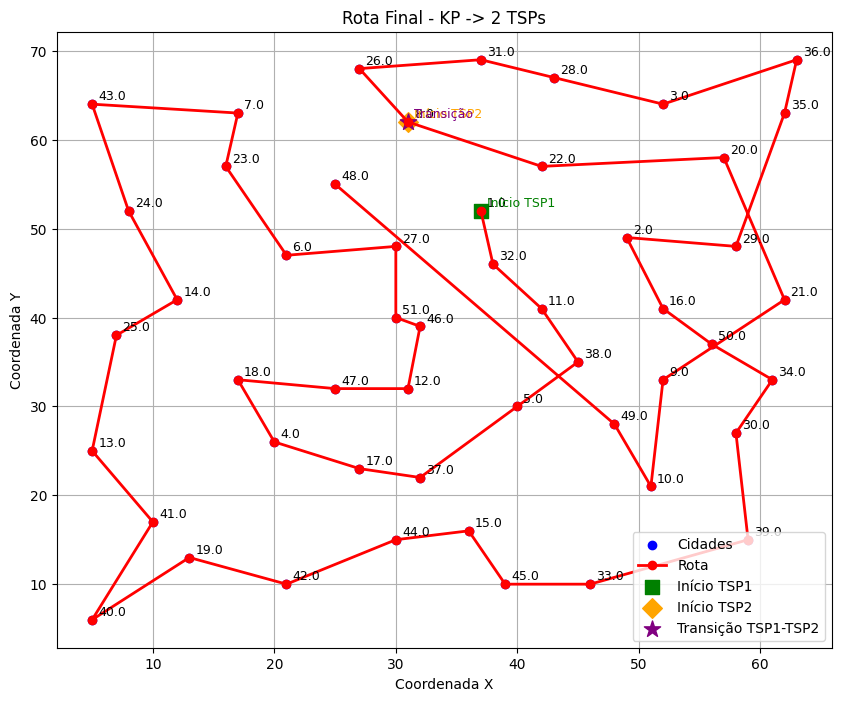

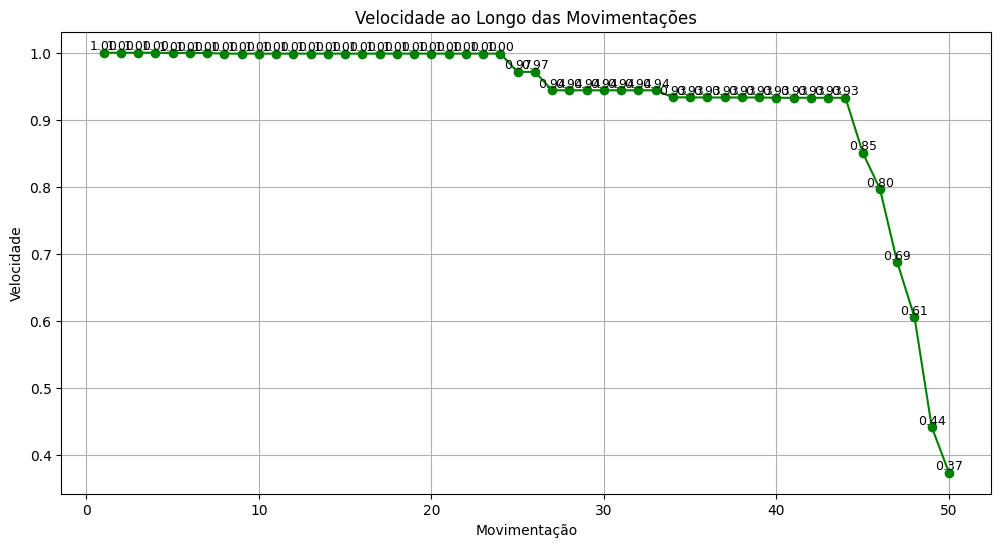

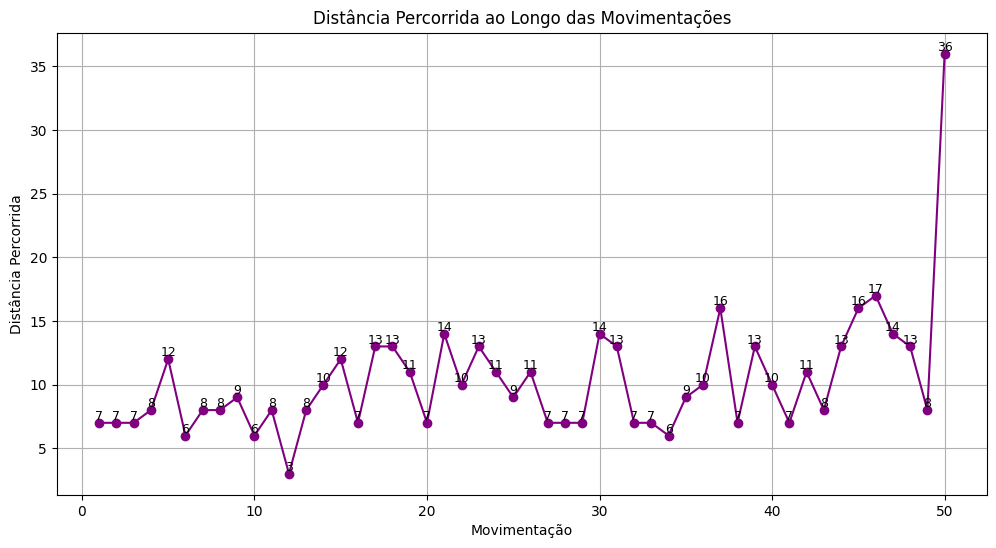

In [30]:

class KPThen2TSPsSolver:
    def __init__(self, instancia):
        """
        Inicializa o solver com a instância do problema.

        Args:
            instancia: Objeto que contém os DataFrames df_cidades e df_itens, 
                      matriz_distancias, capacidade da mochila, velocidades, etc.
        """
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')  # Assegure-se de que o solver está instalado

        # Preprocessamento para garantir que 'cidade' está presente e é inteiro
        if 'cidade' not in self.instancia.df_itens.columns:
            self.instancia.df_itens = self.instancia.df_itens.reset_index().rename(columns={'index': 'cidade'})

        # Converter os identificadores de 'cidade' para inteiros, se necessário
        self.instancia.df_itens['cidade'] = self.instancia.df_itens['cidade'].astype(int)

        # Excluir itens que estão associados a cidades que não existem em df_cidades
        cidades_existentes = set(self.instancia.df_cidades['cidade'].tolist())
        itens_validos = self.instancia.df_itens[self.instancia.df_itens['cidade'].isin(cidades_existentes)]
        itens_invalidos = self.instancia.df_itens[~self.instancia.df_itens['cidade'].isin(cidades_existentes)]
        if not itens_invalidos.empty:
            print(f"Aviso: Alguns itens estão associados a cidades inexistentes e serão ignorados: {itens_invalidos.index.tolist()}")
        self.instancia.df_itens = itens_validos

        # Gerar a matriz de distâncias completa com CEIL_2D
        self._gerar_matriz_distancias()

        # Inicialização das variáveis
        self.itens_selecionados = []
        self.itens_leves = []
        self.itens_pesados = []
        self.rota1 = []
        self.rota2 = []
        self.rota_final = []
        self.lucro_total = 0
        self.velocidades = []  # Lista para armazenar velocidades em cada movimentação
        self.distancias = []    # Lista para armazenar distâncias em cada movimentação

    def _gerar_matriz_distancias(self):
        """
        Gera a matriz de distâncias completa utilizando as coordenadas das cidades.
        Aplica a função CEIL_2D para arredondar as distâncias para cima.
        """
        cidades = self.instancia.df_cidades['cidade'].tolist()
        coordenadas = self.instancia.df_cidades.set_index('cidade')[['x', 'y']].to_dict('index')
        matriz_distancias = {}

        for i in cidades:
            for j in cidades:
                if i != j:
                    xi, yi = coordenadas[i]['x'], coordenadas[i]['y']
                    xj, yj = coordenadas[j]['x'], coordenadas[j]['y']
                    distancia = math.ceil(math.sqrt((xi - xj)**2 + (yi - yj)**2))
                    matriz_distancias[(i, j)] = distancia
                else:
                    matriz_distancias[(i, j)] = 0  # Distância para si mesmo é zero

        self.instancia.matriz_distancias = matriz_distancias
        print("Matriz de distâncias gerada automaticamente com CEIL_2D.")

    def _classificar_cidades(self):
        """
        Classifica as cidades com base nos itens selecionados e seus pesos.
        """
        # Agrupar os itens por cidade e calcular o peso total por cidade
        df_itens_por_cidade = self.instancia.df_itens.groupby('cidade').agg({'weight': 'sum'}).reset_index()
        df_itens_por_cidade.rename(columns={'weight': 'cluster_weight'}, inplace=True)

        # Verificar se 'cidade' já existe em df_cidades
        if 'cidade' not in self.instancia.df_cidades.columns:
            # Resetar o índice e renomear para 'cidade' somente se não existir
            self.instancia.df_cidades = self.instancia.df_cidades.reset_index()
            self.instancia.df_cidades.rename(columns={'index': 'cidade'}, inplace=True)
        else:
            print("A coluna 'cidade' já existe em df_cidades. Evitando duplicação.")

        # Garantir que 'cidade' é única em df_cidades
        if self.instancia.df_cidades['cidade'].duplicated().any():
            raise ValueError("A coluna 'cidade' em df_cidades contém valores duplicados. Por favor, remova ou consolide duplicatas.")

        # Merge com o DataFrame de itens por cidade
        self.instancia.df_cidades = self.instancia.df_cidades.merge(df_itens_por_cidade, on='cidade', how='left')
        self.instancia.df_cidades['cluster_weight'].fillna(-1, inplace=True)

        # Sort the cities by weight cluster (from lightest to heaviest)
        self.instancia.df_cidades.sort_values(by='cluster_weight', ascending=True, inplace=True)

    def solve(self):
        """
        Executa o processo completo de resolução: KP, divisão de itens, 2 TSPs e cálculo do lucro.
        """
        print("Iniciando KPThen2TSPsSolver...")
        self._resolver_kp()
        self._dividir_itens()
        self._resolver_duas_tsp()
        self._unir_rotas()
        self._calcular_ttp()
        print("KPThen2TSPsSolver Finalizado.")

    def _resolver_kp(self):
        """
        Resolve o problema de Knapsack (KP) para selecionar itens que maximizam o lucro.
        """
        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições
        ampl.setOption('solver', 'gurobi')

        modelo_kp = '''
        param m integer;
        param W;

        param Profit {1..m};
        param Weight {1..m};

        var y {1..m} binary;

        maximize TotalProfit:
            sum {k in 1..m} Profit[k] * y[k];

        subject to KnapsackConstraint:
            sum {k in 1..m} Weight[k] * y[k] <= W;
        '''
        ampl.eval(modelo_kp)

        instancia = self.instancia

        # Preparar os índices e parâmetros
        profit_dict = {}
        weight_dict = {}
        item_ids = list(instancia.df_itens.index)
        for idx, item_id in enumerate(item_ids, start=1):
            profit_dict[idx] = instancia.df_itens.loc[item_id]['profit']
            weight_dict[idx] = instancia.df_itens.loc[item_id]['weight']

        ampl.param['m'] = len(item_ids)
        ampl.param['W'] = instancia.capacity
        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict

        ampl.solve()

        y_sol = ampl.getVariable('y').getValues()
        y_values = y_sol.toDict()

        # Selecionar itens com y[k] > 0.5
        self.itens_selecionados = []
        for idx, item_id in enumerate(item_ids, start=1):
            if y_values.get(idx, 0) > 0.5:
                self.itens_selecionados.append(item_id)

        print(f"Itens selecionados (KP): {self.itens_selecionados}")

    def _dividir_itens(self):
        """
        Ordena os itens selecionados por peso e divide em dois grupos: 
        metade mais leve e metade mais pesada.
        """
        if not self.itens_selecionados:
            raise ValueError("Nenhum item selecionado após resolver o KP.")

        # Extrair os pesos dos itens selecionados
        itens_df = self.instancia.df_itens.loc[self.itens_selecionados]

        # Ordenar por peso (crescente)
        itens_ordenados = itens_df.sort_values(by='weight', ascending=True)

        # Dividir em dois grupos
        metade = len(itens_ordenados) // 2
        itens_leves = itens_ordenados.iloc[:metade].index.tolist()
        itens_pesados = itens_ordenados.iloc[metade:].index.tolist()

        self.itens_leves = itens_leves
        self.itens_pesados = itens_pesados

        print(f"Metade mais leve dos itens: {self.itens_leves}")
        print(f"Metade mais pesada dos itens: {self.itens_pesados}")

    def _resolver_duas_tsp(self):
        """
        Resolve dois problemas de TSP separadamente para os grupos de itens leves e pesados.
        Garante que o TSP1 sempre comece na cidade 1 e que o TSP2 inicie no final do TSP1.
        """
        # Identificar as cidades envolvidas em cada grupo
        cidades_leves = self.instancia.df_itens.loc[self.itens_leves]['cidade'].unique().tolist()
        cidades_pesadas = self.instancia.df_itens.loc[self.itens_pesados]['cidade'].unique().tolist()

        # Incluir cidades sem itens no TSP1 (Itens Leves)
        todas_cidades_com_itens_leves = set(cidades_leves)
        todas_cidades_com_itens_pesados = set(cidades_pesadas)
        todas_cidades = set(self.instancia.df_cidades['cidade'].tolist())
        cidades_sem_itens = todas_cidades - todas_cidades_com_itens_leves - todas_cidades_com_itens_pesados

        # Evitar incluir cidade 0 (já filtrado no TTPInstance)
        cidades_sem_itens = [cidade for cidade in cidades_sem_itens if cidade > 0]

        # Depuração: Verificar cidades_sem_itens
        print(f"Cidades_sem_itens (após filtro): {cidades_sem_itens}")

        # Garantir que o TSP1 comece na cidade 1
        if 1 not in cidades_leves:
            cidades_leves.append(1)
            print("Cidade 1 adicionada ao TSP1 para garantir que o TSP1 comece na cidade 1.")

        # Remover a cidade 1 de cidades_sem_itens para evitar duplicação
        cidades_sem_itens = [cidade for cidade in cidades_sem_itens if cidade != 1]

        # Incluir cidades sem itens no TSP1
        cidades_leves += list(cidades_sem_itens)

        # Remover duplicatas mantendo a ordem
        cidades_leves = list(dict.fromkeys(cidades_leves))

        print(f"Cidades para TSP 1 (Itens Leves + Cidades sem itens): {cidades_leves}")
        print(f"Cidades para TSP 2 (Itens Pesados): {cidades_pesadas}")

        # Resolver TSP para itens leves (TSP1)
        self.rota1, fim_tsp1 = self._resolver_tsp_para_cidades(cidades_leves, start_node=1)
        print(f"Rota 1 (Itens Leves + Cidades sem itens): {self.rota1}")
        print(f"Fim TSP1: {fim_tsp1}")

        # Resolver TSP para itens pesados (TSP2), iniciando no fim do TSP1
        if fim_tsp1:
            self.rota2 = self._resolver_tsp_para_cidades(cidades_pesadas, start_node=fim_tsp1)[0]
            print(f"Rota 2 (Itens Pesados): {self.rota2}")
        else:
            print("Nenhuma cidade final do TSP1 para iniciar o TSP2.")
            self.rota2 = []

    def _resolver_tsp_para_cidades(self, cidades_tsp, start_node):
        """
        Resolve o TSP para um subconjunto de cidades com um nó de início específico.

        Args:
            cidades_tsp (list): Lista de identificadores de cidades para o TSP.
            start_node (int): Identificador da cidade de início.

        Returns:
            tuple: (Lista de tuplas representando a rota (i, j), Última cidade da rota)
        """
        # Verificar se 'cidades_tsp' está vazio
        if not cidades_tsp:
            print("Nenhuma cidade para resolver o TSP.")
            return [], None

        # Depuração: Confirmar que 'cidades_tsp' não inclui 0
        if 0 in cidades_tsp:
            print("Erro: Cidade 0 está incluída em cidades_tsp!")
            cidades_tsp = [cidade for cidade in cidades_tsp if cidade > 0]
            print(f"Cidades_tsp corrigido: {cidades_tsp}")

        # Garantir que o start_node está em cidades_tsp
        if start_node not in cidades_tsp:
            print(f"Aviso: start_node {start_node} não está em cidades_tsp. Adicionando-o.")
            cidades_tsp.insert(0, start_node)  # Adicionar start_node no início

        # Remover duplicatas mantendo a ordem
        cidades_tsp = list(dict.fromkeys(cidades_tsp))

        # Depuração: Verificar se 'cidades_tsp' contém duplicatas
        if len(cidades_tsp) != len(set(cidades_tsp)):
            print("Erro: 'cidades_tsp' ainda contém duplicatas após remoção.")

        ampl = self.ampl
        ampl.reset()  # Resetar o ambiente AMPL para evitar redefinições

        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES, NODES};
        param start_node;

        var x{NODES, NODES} binary;
        var u{NODES} >= 0;

        minimize TotalDistance:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j];

        subject to OneOut {i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn {j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination {i in NODES, j in NODES :
            i != j and i != start_node and j != start_node}:
            u[i] - u[j] + n * x[i,j] <= n - 1;

        subject to NoSelfLoop {i in NODES}:
            x[i,i] == 0;
        '''
        ampl.eval(modelo_tsp)

        # Definir sets e parâmetros
        ampl.set['NODES'] = cidades_tsp
        ampl.param['n'] = len(cidades_tsp)
        ampl.param['start_node'] = start_node

        # Verificar a matriz de distâncias
        try:
            self._verificar_matriz_distancias(cidades_tsp)
        except ValueError as e:
            print(e)
            # Retornar rotas que conectam as cidades a si mesmas
            return [(cidade, cidade) for cidade in cidades_tsp], None

        # Converter a matriz de distâncias para o formato adequado
        distance_dict = {}
        for i in cidades_tsp:
            for j in cidades_tsp:
                if i != j:
                    distance = self.instancia.matriz_distancias.get((i, j), 0)
                    if distance > 0:
                        distance_dict[(i, j)] = distance
                    else:
                        # Definir uma distância grande para evitar conexões inválidas
                        distance_dict[(i, j)] = 1e6
                else:
                    distance_dict[(i, j)] = 0  # Distância para si mesmo é zero

        ampl.param['Distance'] = distance_dict

        # Depuração: Confirmar a matriz de distâncias sendo passada
        print(f"Matriz de distâncias para TSP ({len(cidades_tsp)} cidades):")
        for (i, j), dist in distance_dict.items():
            print(f"Distância entre {i} e {j}: {dist}")

        # Resolver o modelo
        ampl.solve()

        # Verificar se a solução é viável
        if ampl.getObjective('TotalDistance').value() is None:
            print("Nenhuma solução viável encontrada para o TSP.")
            # Retornar rotas que conectam as cidades a si mesmas
            return [(cidade, cidade) for cidade in cidades_tsp], None

        # Obter a solução
        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruindo a rota sem permitir visitar a mesma cidade novamente
        rota = []
        current_city = start_node  # Iniciar pela start_node
        rota.append(current_city)
        visited = set([current_city])

        while len(visited) < len(cidades_tsp):
            next_city = None
            for j in cidades_tsp:
                if j not in visited and x_values.get((current_city, j), 0) > 0.5:
                    next_city = j
                    break
            if next_city is None:
                print(f"Não foi possível encontrar a próxima cidade a partir de {current_city}.")
                break  # Nenhuma próxima cidade encontrada
            rota.append(next_city)
            visited.add(next_city)
            current_city = next_city

        # **Não adicionar de volta ao start_node para evitar fechar o ciclo**
        # rota.append(start_node)

        # Transformar a rota em lista de tuplas (i, j)
        rota_tuplas = list(zip(rota[:-1], rota[1:]))

        # Determinar a última cidade da rota
        fim_tsp = rota[-1] if rota else None

        # Depuração: Mostrar a rota reconstruída
        print(f"Solução TSP para as cidades {cidades_tsp}: {rota_tuplas}")
        print(f"Fim da rota: {fim_tsp}")

        return rota_tuplas, fim_tsp

    def _verificar_matriz_distancias(self, cidades_tsp):
        """
        Verifica se todas as combinações de cidades possuem distâncias definidas.

        Args:
            cidades_tsp (list): Lista de identificadores de cidades para o TSP.

        Raises:
            ValueError: Se alguma combinação de cidade não tiver distância definida.
        """
        for i in cidades_tsp:
            for j in cidades_tsp:
                if i != j and (i, j) not in self.instancia.matriz_distancias:
                    raise ValueError(f"Distância entre {i} e {j} não está definida na matriz_distancias.")

    def _unir_rotas(self):
        """
        Une as duas rotas de TSP em uma única rota, evitando redundâncias.
        """
        # Definir a rota final
        self.rota_final = []

        # Adicionar a rota1 (TSP1)
        if self.rota1:
            self.rota_final += self.rota1

        # Conectar a rota1 com a rota2
        if self.rota1 and self.rota2:
            ultima_cidade_rota1 = self.rota1[-1][1]
            primeira_cidade_rota2 = self.rota2[0][0]
            if ultima_cidade_rota1 != primeira_cidade_rota2:
                self.rota_final.append((ultima_cidade_rota1, primeira_cidade_rota2))

        # Adicionar a rota2 (TSP2)
        if self.rota2:
            self.rota_final += self.rota2

        # **Não fechar o ciclo retornando à cidade inicial**

        print(f"Rota final unificada: {self.rota_final}")

    def _calcular_ttp(self):
        """
        Calcula o lucro total considerando a rota final e os itens selecionados, 
        levando em conta a velocidade variável.
        """
        instancia = self.instancia

        # Peso acumulado
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0
        total_distancia = 0  # Variável para armazenar a distância total

        for (i, j) in self.rota_final:
            # Adiciona itens coletados na cidade i
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == i]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcula a velocidade atual
            velocidade = instancia.max_speed - ((peso_acumulado / instancia.capacity) * (instancia.max_speed - instancia.min_speed))
            velocidade = max(velocidade, instancia.min_speed)  # Garantir que a velocidade não seja menor que vmin

            # Armazenar a velocidade para plotagem
            self.velocidades.append(velocidade)

            # Calcular e armazenar a distância percorrida
            distancia = instancia.matriz_distancias.get((i, j), 0)
            self.distancias.append(distancia)
            total_distancia += distancia

            # Tempo para percorrer de i para j
            tempo = distancia / velocidade
            tempo_total += tempo

            print(f"Cidade {i} -> Cidade {j}: Peso acumulado = {peso_acumulado}, "
                  f"Velocidade = {velocidade:.2f}, Tempo = {tempo:.2f}, "
                  f"Distância = {distancia}")

        custo_aluguel = instancia.rent_ratio * tempo_total
        self.lucro_total = lucro_itens - custo_aluguel

        print(f"Tempo total de viagem: {tempo_total:.2f}")
        print(f"Custo de aluguel: {custo_aluguel:.2f}")
        print(f"Lucro total: {self.lucro_total:.2f}")
        print(f"Distância total percorrida: {total_distancia} unidades")

    def resultados(self):
        """
        Exibe os resultados finais da solução.
        """
        print("\n===== KP -> 2 TSPs =====")
        print("\nRota Final:")
        for (i, j) in self.rota_final:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total:.2f}")
        # Calcular e exibir a distância total percorrida
        total_distancia = sum(self.distancias)
        print(f"Distância Total Percorrida: {total_distancia} unidades")

    def plotar_rota_final(self, titulo='Rota Final - KP -> 2 TSPs'):
        """
        Plota a rota final no mapa e marca os pontos de início de cada sub-TSP.

        Args:
            titulo (str): Título do gráfico.
        """
        df_cidades = self.instancia.df_cidades

        # Extrair as cidades da rota final, incluindo a última cidade de chegada
        rota_pontos = [i for (i, j) in self.rota_final] + [self.rota_final[-1][1]] if self.rota_final else []

        # Remover duplicatas consecutivas
        rota_pontos_sem_dup = []
        for cidade in rota_pontos:
            if not rota_pontos_sem_dup or cidade != rota_pontos_sem_dup[-1]:
                rota_pontos_sem_dup.append(cidade)

        rota_pontos = rota_pontos_sem_dup

        # Verificar se todas as cidades na rota estão no DataFrame
        missing_cidades = [cidade for cidade in rota_pontos if cidade not in df_cidades['cidade'].tolist()]
        if missing_cidades:
            print(f"Aviso: As seguintes cidades não estão no DataFrame e serão ignoradas: {missing_cidades}")
            rota_pontos = [cidade for cidade in rota_pontos if cidade in df_cidades['cidade'].tolist()]

        # Obter as coordenadas da rota final
        rota_coords_x = [df_cidades.loc[df_cidades['cidade'] == cidade, 'x'].values[0] for cidade in rota_pontos]
        rota_coords_y = [df_cidades.loc[df_cidades['cidade'] == cidade, 'y'].values[0] for cidade in rota_pontos]

        # Criar figura
        plt.figure(figsize=(10, 8))
        plt.title(titulo)
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')

        # Plotar as cidades
        plt.scatter(df_cidades['x'], df_cidades['y'], c='blue', label='Cidades')

        # Adicionar labels às cidades
        for idx, row in df_cidades.iterrows():
            plt.text(row['x'] + 0.5, row['y'] + 0.5, str(row['cidade']), fontsize=9)

        # Plotar a rota
        plt.plot(rota_coords_x, rota_coords_y, c='red', linestyle='-', linewidth=2, marker='o', label='Rota')

        # Marcar os pontos de início de cada sub-TSP
        if self.rota1:
            rota1_start = self.rota1[0][0]
            rota1_x = df_cidades.loc[df_cidades['cidade'] == rota1_start, 'x'].values[0]
            rota1_y = df_cidades.loc[df_cidades['cidade'] == rota1_start, 'y'].values[0]
            plt.scatter(rota1_x, rota1_y, c='green', marker='s', s=100, label='Início TSP1')
            plt.text(rota1_x + 0.5, rota1_y + 0.5, 'Início TSP1', fontsize=9, color='green')

        if self.rota2:
            rota2_start = self.rota2[0][0]
            rota2_x = df_cidades.loc[df_cidades['cidade'] == rota2_start, 'x'].values[0]
            rota2_y = df_cidades.loc[df_cidades['cidade'] == rota2_start, 'y'].values[0]
            plt.scatter(rota2_x, rota2_y, c='orange', marker='D', s=100, label='Início TSP2')
            plt.text(rota2_x + 0.5, rota2_y + 0.5, 'Início TSP2', fontsize=9, color='orange')

        # Opcional: Marcar o ponto de transição entre TSP1 e TSP2
        if self.rota1 and self.rota2:
            # O ponto de transição é a última cidade de rota1 e a primeira de rota2
            ultima_rota1 = self.rota1[-1][1]
            primeira_rota2 = self.rota2[0][0]
            # Considerando que (ultima_rota1, primeira_rota2) é a conexão
            trans_x = df_cidades.loc[df_cidades['cidade'] == ultima_rota1, 'x'].values[0]
            trans_y = df_cidades.loc[df_cidades['cidade'] == ultima_rota1, 'y'].values[0]
            plt.scatter(trans_x, trans_y, c='purple', marker='*', s=150, label='Transição TSP1-TSP2')
            plt.text(trans_x + 0.5, trans_y + 0.5, 'Transição', fontsize=9, color='purple')

        plt.legend()
        plt.grid(True)
        plt.show()

    def plotar_velocidade(self, titulo='Velocidade ao Longo das Movimentações'):
        """
        Plota a velocidade (eixo Y) ao longo de cada movimentação (eixo X).

        Args:
            titulo (str): Título do gráfico.
        """
        if not self.velocidades:
            print("Nenhuma velocidade registrada para plotagem.")
            return

        # Criar lista de movimentações
        movimentacoes = list(range(1, len(self.velocidades) + 1))

        # Criar figura
        plt.figure(figsize=(12, 6))
        plt.title(titulo)
        plt.xlabel('Movimentação')
        plt.ylabel('Velocidade')

        # Plotar a velocidade
        plt.plot(movimentacoes, self.velocidades, marker='o', linestyle='-', color='green')

        # Adicionar anotações
        for i, v in zip(movimentacoes, self.velocidades):
            plt.text(i, v, f"{v:.2f}", fontsize=9, ha='center', va='bottom')

        plt.grid(True)
        plt.show()

    def plotar_distancia(self, titulo='Distância Percorrida ao Longo das Movimentações'):
        """
        Plota a distância percorrida (eixo Y) ao longo de cada movimentação (eixo X).

        Args:
            titulo (str): Título do gráfico.
        """
        if not self.distancias:
            print("Nenhuma distância registrada para plotagem.")
            return

        # Criar lista de movimentações
        movimentacoes = list(range(1, len(self.distancias) + 1))

        # Criar figura
        plt.figure(figsize=(12, 6))
        plt.title(titulo)
        plt.xlabel('Movimentação')
        plt.ylabel('Distância Percorrida')

        # Plotar a distância
        plt.plot(movimentacoes, self.distancias, marker='o', linestyle='-', color='purple')

        # Adicionar anotações
        for i, d in zip(movimentacoes, self.distancias):
            plt.text(i, d, f"{d}", fontsize=9, ha='center', va='bottom')

        plt.grid(True)
        plt.show()


# Criar uma instância do solver
solver_kp_2tsp = KPThen2TSPsSolver(instancia)

# Resolver o problema
solver_kp_2tsp.solve()

# Exibir os resultados
solver_kp_2tsp.resultados()

# Plotar a rota final
solver_kp_2tsp.plotar_rota_final(titulo='Rota Final - KP -> 2 TSPs')

# Plote a velocidade ao longo das movimentações
solver_kp_2tsp.plotar_velocidade()

solver_kp_2tsp.plotar_distancia()


Testes com segunda instancia>

In [ ]:
# Criar uma instância do solver
solver_kp_2tsp = KPThen2TSPsSolver(instancia)

# Resolver o problema
solver_kp_2tsp.solve()

# Exibir os resultados
solver_kp_2tsp.resultados()

# Plotar a rota final
solver_kp_2tsp.plotar_rota_final(titulo='Rota Final - KP -> 2 TSPs')

# Plote a velocidade ao longo das movimentações
solver_kp_2tsp.plotar_velocidade()

solver_kp_2tsp.plotar_distancia()

Vamos comecar com as Heuristicas, dado que nao conseguimos linearizar o modelo

Resumo da proposta da Heuristica
1) Sabendo que a funcao objetivo do TTP pode ser simplificada como:

   MAX LUCRO   =  MAX(LUCRO KP) - MIN(CUSTO DE LOCACAO TOTAL TSP)

2) Podemos buscar identificar quais os efeitos das variaveis de forma parcial, para tentarmos buscar uma heuristica:

   LUCRO e diretatemnte proporcial as variaveis  <>  "Profit Item"
   LUCRO e inversamente proporcial as variaveis <> "Peso do Item" e "Distancia que o Item tera que percorrer ate o fim do percurso"

3) Tendo isso em mente, podemos ter o seguinte criterio:

   i) Quanto uma cidade possui itens com melhor custo beneficio que outras?
   ii) Podemos classificar os itens em:
        - Muito bom profit e mais Pesado;
        - Muito bom profit e medio Pesado;
        - Muito bom profit e menos Pesado;
        - Bom profit e Mais Pesado;
        - Bom profit e medio Pesado;
        - Bom profit e menos Pesado;
        - Baixo profit e Mais Pesado;
        - Baixo profit e medio Pesado;
        - Bom profit e menos Pesado;

        Para classificar, podemos utilizar a razao Profit/Peso, Profit e Peso.


Separar o cluster de Regioes com grande custo beneficio, para que sejam trilhadas rotas com base nessas subrotas com problemas de TPS divididos e depois consolidados


In [27]:
# Importando bibliotecas necessárias 
import pandas as pd
import re
import math
from amplpy import AMPL, DataFrame
import matplotlib.pyplot as plt  # Importar matplotlib para plotar
import numpy as np
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from amplpy import AMPL, Environment

class TTPHeuristicSolver:
    def __init__(self, instancia, metodo_subtsp='nearest_neighbor'):
        """
        :param instancia: Instance of the TTP problem
        :param metodo_subtsp: Method to solve sub-TSPs. Can be 'ampl_gurobi' or 'nearest_neighbor'
        """
        self.instancia = instancia
        self.metodo_subtsp = metodo_subtsp
        self.df_itens = self.instancia.df_itens.copy()
        self.df_cidades = self.instancia.df_cidades.copy()
        self.num_clusters_itens_ratio = None
        self.num_clusters_itens_weight = None
        self.num_clusters_cidades = None
        self.rota_final = None
        self.itens_selecionados = None
        self.lucro_total = None
        self.sub_tours = {}  # To store the sub-TSPs

        # Initialize the AMPL environment
        self.ampl = AMPL()

    def solve(self):
        self._classificar_itens()
        self._classificar_cidades()
        self._dividir_subtours()
        self._resolver_subtours()
        self._unir_subtours()
        self._selecionar_itens()
        self._calcular_lucro_total()
        self.resultados()

    def _classificar_itens(self):
        # Item classification remains the same
        # Classification of items by ratio
        self.df_itens['ratio'] = self.df_itens['profit'] / self.df_itens['weight']
        scaler_ratio = StandardScaler()
        ratio_scaled = scaler_ratio.fit_transform(self.df_itens[['ratio']])
        self.num_clusters_itens_ratio = 3
        kmeans_ratio = KMeans(n_clusters=self.num_clusters_itens_ratio, random_state=42)
        self.df_itens['cluster_ratio'] = kmeans_ratio.fit_predict(ratio_scaled)

        # Classification of items by weight
        scaler_weight = StandardScaler()
        weight_scaled = scaler_weight.fit_transform(self.df_itens[['weight']])
        self.num_clusters_itens_weight = 3
        kmeans_weight = KMeans(n_clusters=self.num_clusters_itens_weight, random_state=42)
        self.df_itens['cluster_weight'] = kmeans_weight.fit_predict(weight_scaled)

    def _classificar_cidades(self):
        # Classify cities based on the weight classification of the items
        df_itens_por_cidade = self.df_itens.groupby('cidade').agg({
            'cluster_weight': lambda x: x.mode()[0]
        }).reset_index()

        # Reset index and ensure 'cidade' column exists
        self.df_cidades = self.df_cidades.reset_index()
        self.df_cidades.rename(columns={'index': 'cidade'}, inplace=True)

        # Merge with the cities DataFrame
        self.df_cidades = self.df_cidades.merge(df_itens_por_cidade, on='cidade', how='left')
        self.df_cidades['cluster_weight'].fillna(-1, inplace=True)

        # Sort the cities by weight cluster (from lightest to heaviest)
        self.df_cidades.sort_values(by='cluster_weight', ascending=True, inplace=True)
        self.df_cidades.reset_index(drop=True, inplace=True)

    def _dividir_subtours(self):
        # Divide the cities into subgroups based on the weight cluster
        self.sub_tours = {}
        clusters = self.df_cidades['cluster_weight'].unique()
        for cluster in clusters:
            cidades_cluster = self.df_cidades[self.df_cidades['cluster_weight'] == cluster]['cidade'].tolist()
            if cidades_cluster:
                self.sub_tours[cluster] = cidades_cluster

    def _resolver_subtours(self):
        self.sub_tour_routes = {}
        for cluster in sorted(self.sub_tours.keys()):
            cidades = self.sub_tours[cluster]
            if len(cidades) <= 1:
                self.sub_tour_routes[cluster] = cidades
                continue

            if self.metodo_subtsp == 'ampl_gurobi':
                # Solve the sub-TSP optimally using AMPL with Gurobi
                rota_subtour = self._resolver_subtsp_ampl(cidades)
            elif self.metodo_subtsp == 'nearest_neighbor':
                # Use the Nearest Neighbor heuristic to solve the sub-TSP
                rota_subtour = self._resolver_subtsp_nearest_neighbor(cidades)
            else:
                raise ValueError("Invalid method for solving sub-TSPs. Use 'ampl_gurobi' or 'nearest_neighbor'.")

            self.sub_tour_routes[cluster] = rota_subtour

    def _resolver_subtsp_ampl(self, cidades):
        ampl = self.ampl
        ampl.reset()  # Reset the AMPL environment

        # AMPL TSP model adjusted to minimize distance
        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES,NODES};
        param start_node;

        var x{NODES,NODES} binary;
        var u{NODES} >= 0;

        minimize TotalDistance:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j];

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES :
            i != j and i != start_node and j != start_node}:
            u[i] - u[j] + n * x[i,j] <= n - 1;
        '''
        ampl.eval(modelo_tsp)

        # Define sets and parameters
        ampl.set['NODES'] = cidades
        ampl.param['n'] = len(cidades)

        # Extract the distance submatrix for the sub-TSP cities
        distance_dict = {}
        for i in cidades:
            for j in cidades:
                if i != j:
                    distance = self.instancia.matriz_distancias.get((i, j), 0)
                    distance_dict[i, j] = distance
                else:
                    distance_dict[i, j] = 0  # Distance to self is zero

        ampl.param['Distance'] = distance_dict

        # Define the starting node
        ampl.param['start_node'] = cidades[0]  # Defina o nó inicial conforme necessário

        # Select the Gurobi solver
        ampl.setOption('solver', 'gurobi')

        # Solve the model
        ampl.solve()

        # Verificar se a solução é viável
        if ampl.getObjective('TotalDistance').value() is None:
            print("Nenhuma solução viável encontrada para o sub-TSP.")
            return cidades  # Retorna a ordem original das cidades

        # Obter a solução
        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = ampl.getParameter('start_node').value()
        rota.append(current_city)
        visited = set([current_city])

        while len(rota) < len(cidades):
            next_city = None
            for j in cidades:
                if x_values.get((current_city, j), 0) > 0.5 and j not in visited:
                    next_city = j
                    break
            if next_city is None:
                print(f"Não foi possível encontrar a próxima cidade a partir de {current_city}.")
                break  # Nenhuma próxima cidade encontrada
            rota.append(next_city)
            visited.add(next_city)
            current_city = next_city

        return rota

    def _resolver_subtsp_nearest_neighbor(self, cidades):
        # Nearest Neighbor heuristic implementation
        rota = []
        nao_visitadas = set(cidades)
        cidade_atual = cidades[0]
        rota.append(cidade_atual)
        nao_visitadas.remove(cidade_atual)

        while nao_visitadas:
            cidade_mais_proxima = min(
                nao_visitadas,
                key=lambda x: self.instancia.matriz_distancias.get((cidade_atual, x), float('inf'))
            )
            rota.append(cidade_mais_proxima)
            nao_visitadas.remove(cidade_mais_proxima)
            cidade_atual = cidade_mais_proxima

        return rota

    def _unir_subtours(self):
        # Combine the sub-tours into the final route, from lightest to heaviest item clusters
        self.rota_final = []
        for cluster in sorted(self.sub_tour_routes.keys()):
            rota_subtour = self.sub_tour_routes[cluster]
            self.rota_final.extend(rota_subtour)

        # Remove possible duplicates in the final route
        self.rota_final = list(dict.fromkeys(self.rota_final))

        # Ensure the starting city is at the beginning of the route
        if self.rota_final[0] != 0:
            try:
                inicio_index = self.rota_final.index(0)
                self.rota_final = self.rota_final[inicio_index:] + self.rota_final[:inicio_index]
            except ValueError:
                # Starting city is not in the route
                self.rota_final = [0] + self.rota_final

    def _selecionar_itens(self):
        # Item selection remains the same
        capacidade_restante = self.instancia.capacity
        itens_selecionados = []

        for cidade in self.rota_final:
            itens_na_cidade = self.df_itens[self.df_itens['cidade'] == cidade]
            itens_na_cidade = itens_na_cidade.sort_values(by=['cluster_ratio', 'ratio'], ascending=[True, False])

            for _, item in itens_na_cidade.iterrows():
                if item['weight'] <= capacidade_restante:
                    itens_selecionados.append(item.name)
                    capacidade_restante -= item['weight']
                else:
                    continue

        self.itens_selecionados = itens_selecionados

    def _calcular_lucro_total(self):
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0

        instancia = self.instancia
        rota = self.rota_final

        for i in range(len(rota)):
            cidade_atual = rota[i]
            cidade_proxima = rota[(i + 1) % len(rota)]  # Loop back to start at the end

            # Itens coletados na cidade atual
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == cidade_atual]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcular a velocidade atual
            velocidade = instancia.max_speed - ((peso_acumulado / instancia.capacity) * (instancia.max_speed - instancia.min_speed))
            velocidade = max(instancia.min_speed, velocidade)  # Garantir que a velocidade não seja menor que vmin

            # Tempo para percorrer de cidade_atual para cidade_proxima
            distancia = instancia.matriz_distancias.get((cidade_atual, cidade_proxima), 0)
            tempo = distancia / velocidade
            tempo_total += tempo

        custo_aluguel = instancia.rent_ratio * tempo_total

        self.lucro_total = lucro_itens - custo_aluguel

    def plotar_velocidade_ao_longo_da_rota(self):
        instancia = self.instancia
        rota = self.rota_final

        peso_acumulado = 0
        velocidades = []
        cidades_rota = []

        for i in range(len(rota)):
            cidade_atual = rota[i]

            # Itens coletados na cidade atual
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == cidade_atual]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade

            # Calcular a velocidade atual
            velocidade = instancia.max_speed - ((peso_acumulado / instancia.capacity) * (instancia.max_speed - instancia.min_speed))
            velocidade = max(instancia.min_speed, velocidade)  # Garantir que a velocidade não seja menor que vmin

            velocidades.append(velocidade)
            cidades_rota.append(cidade_atual)

        # Plotar o gráfico
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(cidades_rota) + 1), velocidades, marker='o', linestyle='-')
        plt.title('Velocidade ao Longo da Rota')
        plt.xlabel('Posição na Rota')
        plt.ylabel('Velocidade')
        plt.xticks(range(1, len(cidades_rota) + 1), cidades_rota, rotation=90)
        plt.grid(True)
        plt.show()
    
    def plotar_rota_final(self):
        df_cidades = self.df_cidades  # Use o DataFrame correto

        # Verificar as cidades presentes
        print("Cidades em df_cidades['cidade']:", df_cidades['cidade'].unique())
        
        # Coordenadas das cidades
        x_coords = df_cidades.set_index('cidade')['x']
        y_coords = df_cidades.set_index('cidade')['y']
        
        # Verificar o índice de x_coords
        print("Índices em x_coords:", x_coords.index.tolist())

        # Criar figura
        plt.figure(figsize=(10, 8))
        plt.title('Mapa com a Rota Final')
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')

        # Plotar as cidades
        plt.scatter(x_coords, y_coords, c='blue')

        # Adicionar labels às cidades
        for cidade in x_coords.index:
            plt.text(x_coords[cidade] + 0.5, y_coords[cidade] + 0.5, str(cidade), fontsize=9)

        # Obter as coordenadas da rota final
        rota = self.rota_final + [self.rota_final[0]]  # Voltar à cidade inicial
        rota_coords_x = [x_coords[cidade] for cidade in rota]
        rota_coords_y = [y_coords[cidade] for cidade in rota]

        # Plotar a rota
        plt.plot(rota_coords_x, rota_coords_y, c='red', linestyle='-', linewidth=2, marker='o')

        plt.grid(True)
        plt.show()

    def plotar_clusters_cidades(self):
        df_cidades = self.df_cidades

        # Coordenadas das cidades
        x_coords = df_cidades['x']
        y_coords = df_cidades['y']
        clusters = df_cidades['cluster_weight']

        # Mapa de cores
        num_clusters = len(clusters.unique())
        colors = cm.rainbow(np.linspace(0, 1, num_clusters))

        cluster_colors = {cluster: colors[i] for i, cluster in enumerate(sorted(clusters.unique()))}

        # Criar figura
        plt.figure(figsize=(10, 8))
        plt.title('Mapa com os Clusters de Cidades')
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')

        # Plotar as cidades com cores baseadas nos clusters
        for cluster in sorted(clusters.unique()):
            indices = df_cidades[df_cidades['cluster_weight'] == cluster].index
            plt.scatter(df_cidades.loc[indices, 'x'], df_cidades.loc[indices, 'y'], 
                        c=[cluster_colors[cluster]], label=f'Cluster {cluster}')

        # Adicionar labels às cidades
        for idx, row in df_cidades.iterrows():
            plt.text(row['x'] + 0.5, row['y'] + 0.5, str(row['cidade']), fontsize=9)

        plt.legend()
        plt.grid(True)
        plt.show()

    def resultados(self):
        print("===== Custom Heuristic for the TTP =====")
        print("\nFinal Route:")
        print(" -> ".join(map(str, self.rota_final)))

        print("\nSelected Items:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Profit = {item['profit']}, Weight = {item['weight']}, City = {item['cidade']}")

        print(f"\nTotal Profit: {self.lucro_total}")


# Criar e executar o solver heurístico usando o método 'ampl_gurobi' para resolver os sub-TSPs
solver_heuristico = TTPHeuristicSolver(instancia, metodo_subtsp='ampl_gurobi')
solver_heuristico.solve()

# Plotar a velocidade ao longo da rota
solver_heuristico.plotar_velocidade_ao_longo_da_rota()

# Plotar o mapa com a rota final
solver_heuristico.plotar_rota_final()

# Plotar o mapa com os clusters de cidades
solver_heuristico.plotar_clusters_cidades()

c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: The column label 'cidade' is not unique.